In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from matplotlib.colors import Normalize, LogNorm
from yadlt.context import FitContext
from yadlt.utils import combine_distributions, load_and_evaluate_model
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.distribution import Distribution

import logging
from yadlt.log import setup_logger

# Set up the root logger to capture all logs in jupyter notebook
logger = setup_logger()

# If you want to see all messages, including DEBUG:
logger.setLevel(logging.INFO)

In [2]:
from yadlt.plotting.plotting import produce_plot, LABELSIZE, LEGENDSIZE, TICKSIZE, FONTSIZE
from yadlt.utils import compute_delta_ntk
from yadlt.utils import load_data

import numpy as np
from pathlib import Path

FIGRATIO = np.array((5, 3))

# Define your desired axes size
axes_width_inches = 8.0
axes_height_inches = 4.8

THIS = Path.cwd().parent / "doc/figs"

# Set consistent style
plt.rcParams.update({
    'font.size': FONTSIZE,
    'axes.labelsize': LABELSIZE,
    'xtick.labelsize': TICKSIZE,
    'ytick.labelsize': TICKSIZE,
    'legend.fontsize': LEGENDSIZE,
    'figure.dpi': 300,
})

COLOR_AS = 'C0'
COLOR_TS = 'C1'

In [3]:
def make_figure(axes_width=axes_width_inches, axes_height=axes_height_inches,
                left_margin=0.9, right_margin=0.1,
                bottom_margin=0.7, top_margin=0.1):
  # Calculate total figure size
  figwidth = left_margin + axes_width + right_margin
  figheight = bottom_margin + axes_height + top_margin

  fig = plt.figure(figsize=(figwidth, figheight))

  # Position axes precisely
  ax = fig.add_axes([left_margin/figwidth, bottom_margin/figheight,
                    axes_width/figwidth, axes_height/figheight])
  return fig, ax

In [4]:
context_L0 = FitContext("251017-01-L0-nnpdf-like")
context_L1 = FitContext("251017-02-L1-nnpdf-like")
context_L2 = FitContext("251017-03-L2-nnpdf-like")

# ctx_L0_large = FitContext("251017-04-L0-large")
# ctx_L1_large = FitContext("251017-05-L1-large")
# ctx_L2_large = FitContext("251017-06-L2-large")

fk_grid = context_L0.load_fk_grid()
f_in = context_L0.load_f_bcdms()
FK = context_L0.load_fk_table()

In [5]:
from yadlt.utils import produce_model_at_initialisation

f0 = produce_model_at_initialisation(context_L0.get_property("nreplicas"), tuple(fk_grid), tuple(context_L0.get_config("metadata", "model_info")["architecture"]), seed=2143141)

# Section 2

## Network at initialization

In [ ]:
fig, ax = make_figure()
produce_plot(fk_grid, 
             [f0], 
             ax=ax
)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$xT_3(x)$")
ax.get_legend().set_visible(False)
fig.savefig(THIS / "section_2/prior.pdf", bbox_inches='tight')

ax.set_xscale("log")
fig.savefig(THIS / "section_2/prior_log.pdf", bbox_inches='tight')

# Section 3

## NTK at initialization

In [ ]:
import pickle

fig, ax = make_figure(axes_width=8.0, axes_height=4.8, top_margin=0.5, bottom_margin=0.92)
SERIALIZATION_FOLDER = Path.cwd() / "serialization"
ARCHITECTURES = [
    [10, 10],
    [25, 20],
    [100, 100],
    [1000, 1000],
    # [2000, 2000],
    # [10000, 10000],
]

group_dict = {}
for arch in ARCHITECTURES:
  ntk_by_reps = pickle.load(open(SERIALIZATION_FOLDER / f"ntk_initialization_{arch[0]}.pkl", "rb"))
  eigvals_by_reps = pickle.load(open(SERIALIZATION_FOLDER / f"eigvals_initialization_{arch[0]}.pkl", "rb"))
  frob_norm_by_reps = pickle.load(open(SERIALIZATION_FOLDER / f"frob_norm_initialization_{arch[0]}.pkl","rb",))

  group_dict[tuple(arch)] = {
    "ntk": ntk_by_reps,
    "eigvals": eigvals_by_reps,
    "frob_norm": frob_norm_by_reps,
  }

# X-axis labels for architectures
x_labels_ax1 = [rf"$[{a[0]},{a[1]}]$" for a in ARCHITECTURES]
x_positions_ax1 = np.arange(len(ARCHITECTURES))

# Compute and plot eigenvalues for each architecture
mean_eigvals_by_arch = []
std_eigvals_by_arch = []
for arch in group_dict.values():
    eigvals = arch["eigvals"]
    tmp_mean = [mean for mean in eigvals.get_mean()[:5]]
    tmp_std = [std for std in eigvals.get_std()[:5]]
    mean_eigvals_by_arch.append(tmp_mean)
    std_eigvals_by_arch.append(tmp_std)

mean_eigvals_by_arch = np.array(mean_eigvals_by_arch)  # [arch, eigvals]
std_eigvals_by_arch = np.array(std_eigvals_by_arch)  # [arch, eigvals]

# Store handles for legend
handles = []
labels = []

for idx in range(mean_eigvals_by_arch.shape[1]):
    means = mean_eigvals_by_arch[:, idx]
    stds = std_eigvals_by_arch[:, idx]

    # Plot the eigenvalues with error bars
    line = ax.errorbar(
        x_positions_ax1,
        means,
        yerr=stds,
        fmt="o",
        capsize=2,
        markersize=4,
        label=rf"$\lambda^{{({idx + 1})}}$",
        color=f"C{idx}",
    )

    # Plot horizontal line for last architecture
    ax.axhline(
        y=mean_eigvals_by_arch[-1, idx],
        color=line[0].get_color(),
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
    )

    handles.append(line)
    labels.append(rf"$\lambda^{{({idx + 1})}}$")

    for i, (m, s) in enumerate(zip(means, stds)):
        ax.fill_between(
            [i - 0.1, i + 0.1],
            [m - s, m - s],
            [m + s, m + s],
            alpha=0.2,
            color=f"C{idx}",
        )

    ax.set_xlabel(r"${\rm Architecture}$")
    ax.set_ylabel(r"$\textrm{NTK eigenvalues}$", fontsize=LABELSIZE)
    ax.set_title(r"$\textrm{NTK with different architectures}$", fontsize=FONTSIZE)
    ax.set_xticks(x_positions_ax1)
    ax.set_xticklabels(x_labels_ax1, rotation=45, fontsize=TICKSIZE)
    ax.set_yscale("log")

ax.legend(handles, labels, fontsize=LEGENDSIZE)
fig.savefig(THIS / "section_3/ntk_initialization_arch.pdf")

## $\delta \Theta$

In [ ]:
fitlabels = ["$\\textrm{L0}$", "$\\textrm{L1}$", "$\\textrm{L2}$"]
fitcolors = ["C0", "C1", "C2"]
dist_grids = []
epochs = context_L0.get_config("replicas", "common_epochs")
for idx, ctx  in enumerate([context_L0, context_L1, context_L2]):
    context = ctx
    data_type = context.get_config("metadata", "arguments")["data"]
    delta_ntk_distribution_by_epoch = compute_delta_ntk(context)
    assert np.array_equal(epochs, context.get_config("replicas", "common_epochs")), "Epochs do not match across fits."
    dist_grids.append(delta_ntk_distribution_by_epoch)


fig, ax = make_figure(axes_width=8.0, axes_height=4.8)

produce_plot(
  epochs[1::],
  dist_grids,
  xlabel=r"${\rm Epochs}$",
  ylabel=r"$\delta \Theta$",
  labels=fitlabels,
  colors=fitcolors,
  ax=ax
)

ax.set_xscale("log")
ax.set_ylim(0., 0.065)
ax.set_xlim(1e2, 5e4)
fig.savefig(THIS / "section_3/delta_ntk.pdf")

## $\delta \Theta$ architecture

In [ ]:
fitlabels = [r"$\textrm{[25,20]}$", r"$\textrm{[100,100]}$"]
fitcolors = ["C0", "C1"]
dist_grids = []
epochs = context_L0.get_config("replicas", "common_epochs")
for idx, ctx  in enumerate([context_L0, ctx_L0_large]):
    context = ctx
    data_type = context.get_config("metadata", "arguments")["data"]
    delta_ntk_distribution_by_epoch = compute_delta_ntk(context)
    # assert np.array_equal(epochs, context.get_config("replicas", "common_epochs")), "Epochs do not match across fits."
    dist_grids.append(delta_ntk_distribution_by_epoch)


fig, ax = make_figure(axes_width=8.0, axes_height=4.8)

produce_plot(
  epochs[1::],
  dist_grids,
  xlabel=r"${\rm Epochs}$",
  ylabel=r"$\delta \Theta$",
  labels=fitlabels,
  colors=fitcolors,
  ax=ax
)

ax.set_xscale("log")
ax.set_ylim(0., 0.08)
ax.set_xlim(1e3, 5e4)
fig.savefig(THIS / "appendix_arch/delta_ntk_arch.pdf")

## NTK hierarchy training

In [ ]:
from yadlt.utils import combine_distributions


def plot_by_ctx(ctx, label):
  fig, ax = make_figure(axes_width=8.0, axes_height=4.8)
  epochs = ctx.get_config("replicas", "common_epochs")
  ylabel = r"$\textrm{NTK eigenvalues}$"
  labels = [r"$\lambda^{(1)}$", r"$\lambda^{(2)}$", r"$\lambda^{(3)}$", r"$\lambda^{(4)}$", r"$\lambda^{(5)}$"]
  colors = ["C0", "C1", "C2", "C3", "C4"]
  eigvals = [1, 2, 3, 4, 5]
  eigval = combine_distributions(ctx.eigvals_time)
  all_slices = [eigval.slice((slice(None), idx_eig - 1)) for idx_eig in eigvals]

  produce_plot(
      epochs,
      all_slices,
      scale="linear",
      colors=colors,
      labels=labels,
      xlabel=r"${\rm Epochs}$",
      ylabel=ylabel,
      ax=ax,
      show_68_percentile=False,
      percentile=(16, 84),
      central_statistics="median",
  )

  ax.grid(True, which="major", linestyle="--", linewidth=0.5)
  ax.text(0.05, 0.7, rf"$\rm{{{label}}}$", transform=ax.transAxes, fontsize=FONTSIZE, 
          bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', pad=0.5),
          verticalalignment='top')
  ax.set_yscale("log")
  ax.set_xscale("log")
  ax.set_xlim(1e2, 5e4)
  fig.savefig(THIS / f"section_3/ntk_eigvals_single_plot_{label}.pdf")

plot_by_ctx(context_L0, "L0")
plot_by_ctx(context_L1, "L1")
plot_by_ctx(context_L2, "L2")

## NTK hierarchy training architecture

In [ ]:
from yadlt.utils import combine_distributions
fig, ax = make_figure(axes_width=8.0, axes_height=4.8)

ctx_nnpdf = context_L0
ctx_large = ctx_L0_large
epochs = ctx_nnpdf.get_config("replicas", "common_epochs")

ylabel = r"$\textrm{NTK eigenvalues}$"
fitlabels = [r"$\textrm{[25,20]}$", r"$\textrm{[100,100]}$"]
fitcolors = ["C0", "C1"]
eigvals = [1, 2, 3]

eigval_nnpdf = combine_distributions(ctx_nnpdf.eigvals_time)
eigval_large = combine_distributions(ctx_large.eigvals_time)

all_slices_nnpdf = [eigval_nnpdf.slice((slice(None), idx_eig - 1)) for idx_eig in eigvals]
all_slices_large = [eigval_large.slice((slice(None), idx_eig - 1)) for idx_eig in eigvals]

produce_plot(
    epochs,
    all_slices_nnpdf + all_slices_large,
    scale="linear",
    colors=fitcolors,
    labels=fitlabels,
    xlabel=r"${\rm Epochs}$",
    ylabel=ylabel,
    ax=ax,
    group_size=len(eigvals),
    show_68_percentile=False,
    percentile=(16, 84),
    central_statistics="median",
)

ax.grid(True, which="major", linestyle="--", linewidth=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e3, 5e4)
fig.savefig(THIS / "appendix_arch/ntk_eigvals_single_plot_arch.pdf")

## Eigenvalues of $\Theta$ L0 L1 L2

In [ ]:
eigvals1_by_ctx = []
eigvals2_by_ctx = []
eigvals3_by_ctx = []
eigvals4_by_ctx = []
eigvals5_by_ctx = []

for ctx in [context_L0, context_L1, context_L2]:
    eigval = combine_distributions(ctx.eigvals_time)
    eigvals1_by_ctx.append(eigval.slice((slice(None), 0)))
    eigvals2_by_ctx.append(eigval.slice((slice(None), 1)))
    eigvals3_by_ctx.append(eigval.slice((slice(None), 2)))
    eigvals4_by_ctx.append(eigval.slice((slice(None), 3)))
    eigvals5_by_ctx.append(eigval.slice((slice(None), 4)))

In [ ]:
list_of_eigvals_by_ctx = [
    eigvals1_by_ctx,
    eigvals2_by_ctx,
    eigvals3_by_ctx,
    eigvals4_by_ctx,
    eigvals5_by_ctx,
]

epochs = context_L0.get_config("replicas", "common_epochs")
common_epochs = context_L0.get_config("replicas", "common_epochs")

add_grid_dict = {
    "mean": np.zeros_like(common_epochs),
    "spec": {
        "linestyle": "--",
        "color": "black",
    },
}

for idx in range(5):
  fig, ax = make_figure()

  produce_plot(
      epochs,
      list_of_eigvals_by_ctx[idx],
      additional_grids=None if (idx==0 or idx==1) else [add_grid_dict],
      scale="linear",
      colors=["C0", "C1", "C2"],
      labels=["$\\textrm{L0}$", "$\\textrm{L1}$", "$\\textrm{L2}$"],
      xlabel=r"${\rm Epochs}$",
      ylabel=rf"$\lambda^{{({idx+1})}}$",
      ax=ax,
      show_68_percentile=False,
      percentile=(16, 84),
      central_statistics="median",
  )

  ax.set_xscale("log")
  ax.set_xlim(1e2, 5e4)
  if idx == 0:
      ax.set_ylim(1e2, 2e2)
  fig.savefig(THIS / f"section_3/ntk_eigvals_L0_L1_L2_n_{idx+1}.pdf")

## Loss function

In [ ]:
from yadlt.distribution import Distribution

def collect_loss_histories(context):
  nreplicas = context.get_all_properties()['nreplicas']
  epochs = context.load_epoch_history(0)
  loss_dis = Distribution("Loss ensemble by epoch", size = nreplicas, shape=(epochs.size, ))
  for rep in range(nreplicas):
    loss = context.load_loss_history(rep)
    # Check if negative loss values are present
    if np.any(loss < 0):
        print(f"Warning: Negative loss values found in replica {rep}.")
    loss_dis.add(loss)
  return loss_dis, epochs

def plot_by_ctx(ctx, label):
  loss, epochs = collect_loss_histories(ctx)
  eigval_t = combine_distributions(ctx.eigvals_time)
  eigval_1 = eigval_t.slice((slice(None), 0))
  eigval_2 = eigval_t.slice((slice(None), 1))
  eigval_3 = eigval_t.slice((slice(None), 2))
  eigval_4 = eigval_t.slice((slice(None), 3))
  eigval_5 = eigval_t.slice((slice(None), 4))

  fig, ax1 = make_figure(right_margin=0.7)
  rep = 4

  # Plot first curve on left y-axis
  color1 = 'tab:blue'
  ax1.set_xlabel(r"$\rm{Epochs}$", fontsize=LABELSIZE)
  ax1.set_ylabel(r'$\textrm{Loss Function}$', fontsize=LABELSIZE)
  line1 = ax1.plot(epochs, loss[rep], color=color1, linewidth=2, label=r"$\textrm{Loss Function}$")
  ax1.tick_params(axis='y')
  ax1.axvspan(1.5e3, 5e3, alpha=0.2, color='grey')

  # Create second y-axis that shares the same x-axis
  ax2 = ax1.twinx()

  # Plot second curve on right y-axis
  ax2.set_ylabel(r"$\lambda$", fontsize=LABELSIZE)
  _ = ax2.plot(epochs, eigval_1[rep], color="tab:red", linewidth=2, label=r"$\lambda^{(1)}$")
  _ = ax2.plot(epochs, eigval_2[rep], color="tab:green", linewidth=2, label=r"$\lambda^{(2)}$")
  _ = ax2.plot(epochs, eigval_3[rep], color="tab:orange", linewidth=2, label=r"$\lambda^{(3)}$")
  _ = ax2.plot(epochs, eigval_4[rep], color="tab:purple", linewidth=2, label=r"$\lambda^{(4)}$")
  _ = ax2.plot(epochs, eigval_5[rep], color="tab:brown", linewidth=2, label=r"$\lambda^{(5)}$")
  ax2.tick_params(axis='y')

  # Add title and legend
  # plt.title(r"$\textrm{Loss Function and Top 5 NTK Eigenvalues vs Epochs (Replica %d)}$" % rep)

  # Combine legends from both axes
  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()

  ax2.legend(lines1 + lines2, labels1 + labels2, loc='center left', fontsize=LEGENDSIZE, ncol=2)

  ax1.set_xscale('log')
  ax1.set_yscale('log')
  ax2.set_yscale('log')
  # ax1.set_ylim(4.5e2, 2e3)

  # Adjust layout and show
  # plt.tight_layout()
  ax2.grid(True, alpha=0.3)
  fig.savefig(THIS / f"section_3/loss_and_eigvals_vs_epochs_{label}.pdf")

plot_by_ctx(context_L0, "L0")
plot_by_ctx(context_L1, "L1")
plot_by_ctx(context_L2, "L2")

## NTK alignment with M

In [ ]:
context = context_L2
replica = 4
cut_noise = 20
epochs = [50, 5000, 50000]

eigvecs_time = context.eigvecs_time
cut_by_epoch = context.cut_by_epoch
common_epochs = context.get_config("replicas", "common_epochs")

# Compute eigvals and eigvecs of M
m, W = np.linalg.eigh(context.get_M())
m = m[::-1]
W = W[:, ::-1]

gridspec_kw = {"left": 0.07, "right": 0.93, "top": 0.99, "bottom": 0.05}
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.1, **gridspec_kw)

# Create axes
ax1 = fig.add_subplot(gs[0, 0])  # Left plot
ax2 = fig.add_subplot(gs[0, 1])  # Left plot
ax3 = fig.add_subplot(gs[0, 2])  # Left plot
cax = fig.add_subplot(gs[0, 3])  # Colorbar axis
axs = [ax1, ax2, ax3]

matrices = []
cut_values = []

# Compute the overlap matrices for each reference epoch
for ref_epoch in epochs:
    Z = eigvecs_time[common_epochs.index(ref_epoch)]
    cut = cut_by_epoch[common_epochs.index(ref_epoch)]
    A = np.power(Z[replica].T @ W, 2)
    cut_value = cut[replica]
    cut_values.append(cut_value)
    matrices.append(A[0:cut_noise, :])

vmin = min(np.percentile(A, 5) for A in matrices)
vmax = max(np.percentile(A, 95) for A in matrices)

for idx, ax in enumerate(axs):

    # Create torn edge
    np.random.seed(42)
    torn_edge = 19.5 + np.random.uniform(-0.7, 0.7, matrices[idx].shape[1])
    x_edge = np.arange(matrices[idx].shape[1])

    # Plot the torn edge
    ax.fill_between(
        x_edge - 0.5,
        torn_edge,
        20,
        color="white",
        zorder=3,
        edgecolor="black",
        linewidth=1,
    )

    ms = ax.matshow(
        matrices[idx],
        cmap=mpl.colormaps["RdBu_r"],
        norm=Normalize(vmin=vmin, vmax=vmax, clip=True),  # clip=True will clip out-of-range values
        interpolation=None,
    )

    # Plot horizontal and vertical lines at the cut value
    ax.axhline(y=cut_values[idx], color="white", linestyle="--", linewidth=2)
    # ax.set_title(rf"$T = {epochs[idx]}$", pad=10)
    # Add text with white box
    ax.text(0.7, 0.3, rf"$T = {epochs[idx]}$", 
            transform=ax.transAxes,  # Use axes coordinates (0-1)
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', pad=0.5),
            fontsize=16,
            verticalalignment='top')

    # ax.tick_params(labelsize=TICKSIZE)
    ax.spines["bottom"].set_visible(False)

cbar = plt.colorbar(ms, cax=cax, extend="both")
cbar.ax.yaxis.set_label_position("left")

# Get the actual position of one of your matshow plots (they should all be the same height)
pos = ax1.get_position()
cax_pos = cax.get_position()
cax.set_position([cax_pos.x0, pos.y0, cax_pos.width, pos.height])

ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")
ax3.xaxis.set_ticks_position("top")
ax2.yaxis.set_visible(False)
ax3.yaxis.set_visible(False)


ax1.set_ylabel(r"$\textrm{NTK Eigenvectors }$", fontsize=LABELSIZE)
ax2.set_xlabel(r"$\textrm{FK Eigenvectors}$", fontsize=LABELSIZE, labelpad=20)

fig.savefig(THIS / "section_3/ntk_alignment_L2.pdf", bbox_inches='tight')

## NTK alignment with $f^{(in)}$

In [ ]:
from yadlt.utils import combine_distributions
fig, ax = make_figure(axes_width=8.0, axes_height=4.8, left_margin=1.0)

context = context_L2
eig_ids = [4,5,6]#[0,1,2,3]

eigvecs_time = context.eigvecs_time
common_epochs = context.get_config("replicas", "common_epochs")

# Retrieve the input PDF
fin = context.load_f_bcdms()
cos_theta_by_time = []

# Compute cos of the angle between the eigenvectors of the NTK and the input PDF
for epoch in common_epochs:
    Z = eigvecs_time[common_epochs.index(epoch)]
    fin_normalised = fin / np.linalg.norm(fin, axis=0)
    cos_theta = Z.transpose() @ fin_normalised
    sq_cos_theta = cos_theta.apply_operator(2 , lambda a, b: np.power(a, b))
    cos_theta_by_time.append(cos_theta)

cos_theta_combined = combine_distributions(cos_theta_by_time)

grids = []
for idx_eig in eig_ids:
    sliced_distribution = cos_theta_combined.slice((slice(None), idx_eig))
    sliced_distribution.set_name(rf"$k = {idx_eig + 1}$")
    grids.append(sliced_distribution)

# Create auxiliary grid for horizontal line at zero
add_grid_dict = {
    "mean": np.zeros_like(common_epochs),
    "spec": {
        "linestyle": "--",
        "color": "black",
    },
}

# Produce the plot
produce_plot(
    common_epochs,
    grids,
    xlabel=r"${\rm Epoch}$",
    ylabel=r"$\cos \theta^{(k)}$",
    additional_grids=[add_grid_dict],
    ax=ax,
    # percentile=[16, 84]
)

ax.set_xscale("log")
fig.savefig(THIS / f"section_3/ntk_alignment_fin_L2_2.pdf")

## Plot NTK directions

## Plot eigenvectors

In [ ]:
from yadlt.utils import load_and_evaluate_model

common_epochs = context.get_config("replicas", "common_epochs")
ref_epoch = 5000
epoch_idx = -1 if ref_epoch == -1 else common_epochs.index(ref_epoch)
fk_grid = context.load_fk_grid()
M = context.get_M()
Cy = context.load_bcdms_cov()
Cinv = np.linalg.inv(Cy)
FK = context.load_fk_table()
Y = load_data(context)

Q = context.Q_by_epoch[epoch_idx]
hinv = context.hinv_by_epoch[epoch_idx].make_diagonal()

Qt = Q.transpose()
f = load_and_evaluate_model(context, epoch=ref_epoch)

fk_grid = context.load_fk_grid()

Q = context.Q_by_epoch[epoch_idx]
# hinv = context.hinv_by_epoch[epoch_idx].make_diagonal()

Qt = Q.transpose()
vec = Qt @ f

#################################

Q1 = Q.slice((slice(None), 0))
Q2 = Q.slice((slice(None), 1))
Q3 = Q.slice((slice(None), 2))
Q4 = Q.slice((slice(None), 3))
Q5 = Q.slice((slice(None), 4))

Q_ranks = [Q1, Q2, Q3, Q4, Q5]

################################

fig = plt.figure(figsize=(15, 17))
gs = GridSpec(5, 5, width_ratios=[1, 0.05, 1, 1, 1], wspace=0.25, hspace=0.45)
rank_max = 5

for idx, rank in enumerate(range(rank_max)):
  
  # Create axes
  ax1 = fig.add_subplot(gs[idx, 0])  # Left plot
  cax = fig.add_subplot(gs[idx, 1])  # Colorbar in middle
  ax2 = fig.add_subplot(gs[idx, 2])  # Right plot
  ax3 = fig.add_subplot(gs[idx, 3]) 
  ax4 = fig.add_subplot(gs[idx, 4]) 

  # Create a colormap for consistent colors
  vec_values = [vec[rep][rank] for rep in range(Q1.size)]
  cmap = plt.cm.viridis
  norm = plt.Normalize(vmin=min(vec_values), vmax=max(vec_values))
  colors = cmap(norm(vec_values))

  Q_rank = Q_ranks[rank]
  vec_rank = vec.slice((rank,))

  total = []
  total_sign = []
  for rep in range(Q1.size):
      ax1.plot(fk_grid, Q_rank[rep], color=colors[rep], alpha=0.7, linewidth=1)
      scatter = ax2.scatter(rep, vec_rank[rep], color=colors[rep], s=20, alpha=0.8)
      total.append(Q_rank[rep] * vec_rank[rep])
      total_sign.append(Q_rank[rep] * np.sign(vec_rank[rep]))
  
  total = np.array(total)
  total_sign = np.array(total_sign)
  
  ax3.plot(fk_grid, total.mean(axis=0), color='black', linewidth=2, label=r"$\rm{Mean~over~replicas}$")
  ax3.fill_between(fk_grid, total.mean(axis=0) - total.std(axis=0), total.mean(axis=0) + total.std(axis=0), color='gray', alpha=0.3, label=r"$\rm{1\sigma~band}$")

  ax4.plot(fk_grid, total_sign.mean(axis=0), color='black', linewidth=2, label=r"$\rm{Mean~over~replicas}$")
  ax4.fill_between(fk_grid, total_sign.mean(axis=0) - total_sign.std(axis=0), total_sign.mean(axis=0) + total_sign.std(axis=0), color='gray', alpha=0.3, label=r"$\rm{1\sigma~band}$")  

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  sm.set_array([])
  cbar = fig.colorbar(sm, cax=cax)
  cbar.ax.yaxis.set_ticks_position('left')

  # Labels and titles
  ax1.set_xlabel(r'$x$', fontsize=14)
  ax1.set_ylabel(rf'$\mathbf{{q}}^{{({rank+1})}}$', fontsize=14)
  ax1.set_title(rf"$\rm{{Vector}}~\mathbf{{q}}^{{({rank+1})}}~\textrm{{per replica}}$", fontsize=14)
  ax1.grid(True, alpha=0.3)

  ax2.set_title(rf"$\rm{{Coefficients}}~\tilde{{q}}^{{({rank+1})}}~\textrm{{per replica}}$", fontsize=14)
  ax2.set_xlabel(r'$\textrm{Replica Index}$', fontsize=14)
  ax2.set_ylabel(rf'$\tilde{{q}}_{rank+1}$', fontsize=14, labelpad=-7)
  ax2.grid(True, alpha=0.3)

  ax3.set_title(rf"$\mathbf{{q}}^{{({rank+1})}}\tilde{{q}}_{{{rank+1}}}$", fontsize=14)
  ax3.set_xlabel(r'$x$', fontsize=14)
  ax3.grid(True, alpha=0.3)

  ax4.set_title(rf"$\mathbf{{q}}^{{({rank+1})}} \rm{{sign}}\tilde{{q}}_{{{rank+1}}}$", fontsize=14)
  ax4.set_xlabel(r'$x$', fontsize=14)
  ax4.grid(True, alpha=0.3)

fig.suptitle(rf'$\textrm{{Break-down of }}\mathbf{{f}}(x) = \sum_i \tilde{{q}}_i \mathbf{{q}}^{{(i)}}(x)~\textrm{{at }} T_{{\rm ref}} = {ref_epoch}$', fontsize=16, y=0.92)

plt.show()
# fig.savefig(f"Q_decomposition_{ref_epoch}.pdf", bbox_inches='tight')

In [ ]:
from yadlt.utils import load_and_evaluate_model

def plot_Q_directions_custom(
    context: FitContext,
    ref_epoch: 0,
    ranks: list[int],
    colors: list[str],
    sign: bool = False,
    **plot_kwargs,
):
    """Plot the vectors in Q, which are the combinations
    of the NTK directions and the FK table."""
    common_epochs = context.get_config("replicas", "common_epochs")
    epoch_idx = -1 if ref_epoch == -1 else common_epochs.index(ref_epoch)
    f = load_and_evaluate_model(context, epoch=ref_epoch)

    fk_grid = context.load_fk_grid()
    Q = context.Q_by_epoch[epoch_idx]

    Qt = Q.transpose()
    vec = Qt @ f

    grids = []
    for idx in ranks:
        # Slice the distribution and select the n-th vector
        grid = Q.slice((slice(None), idx - 1))
        vec_rank = vec.slice((idx - 1,))
        tmp_dist = Distribution(f"q_vector_{idx}")
        for rep in range(Q.size):
            if sign:
              tmp_dist.add(grid[rep] * np.sign(vec_rank[rep]))
            else:
              tmp_dist.add(grid[rep] * vec_rank[rep])

        grids.append(tmp_dist)

    grids.append(f)

    produce_plot(
        fk_grid,
        grids,
        xlabel=r"$x$",
        ylabel=r"$\pmb{q}$",
        # labels=fitlabels,
        colors=colors,
        **plot_kwargs,
    )

In [ ]:
epochs = [50, 500, 1000, 10000]
sign = True
context = context_L1

nrows = 2
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": "row", 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)
 
for idx, epoch in enumerate(epochs):
    plot_Q_directions_custom(
        context,
        ref_epoch=epoch,
        ranks=[1,2,3],
        colors=["C0", "C1", "C2", "grey"],
        ax=axes[0, idx],
        labels=[r"$\boldsymbol{q}_1(x)$", r"$\boldsymbol{q}_2(x)$", r"$\boldsymbol{q}_3(x)$", "$f(x)$"],
        sign=sign
    )
    plot_Q_directions_custom(
        context,
        ref_epoch=epoch,
        ranks=[4, 5],
        colors=["C3", "C4", "grey"],
        ax=axes[1, idx],
        labels=[r"$\boldsymbol{q}_4(x)$", r"$\boldsymbol{q}_5(x)$", "$f(x)$"],
        sign=sign,
    )
    axes[0, idx].text(0.1, 0.90, fr"$T={epoch}$", transform=axes[0, idx].transAxes, fontsize=16)
    axes[0, idx].set_xlabel(r"$x$", fontsize=16)
    axes[0, idx].set_ylabel(None)
    # axes[1, idx].text(0.65, 0.90, fr"$T={epoch}$", transform=axes[1, idx].transAxes, fontsize=16)
    axes[1, idx].set_xlabel(r"$x$", fontsize=16)
    axes[1, idx].set_ylabel(None)

    if idx != 0:
        axes[0, idx].get_legend().remove()
        axes[1, idx].get_legend().remove()
    else:
        axes[0, idx].set_ylabel(r"$\pmb{q}(x)$", fontsize=16)
        axes[1, idx].set_ylabel(r"$\pmb{q}(x)$", fontsize=16)
      

fig.savefig(THIS / "section_3/q_directions_sign.pdf", bbox_inches='tight')

### Plot NTK directions

In [ ]:
from yadlt.distribution  import Distribution
from yadlt.utils import load_data

def plot_ntk_directions_custom(
    context: FitContext,
    ref_epoch: 0,
    ranks: list[int],
    colors: list[str],
    **plot_kwargs,
):
    """Plot the vectors in Q, which are the combinations
    of the NTK directions and the FK table."""
    common_epochs = context.get_config("replicas", "common_epochs")
    epoch_idx = -1 if ref_epoch == -1 else common_epochs.index(ref_epoch)
    eigvecs_time = context.eigvecs_time

    Z = eigvecs_time[epoch_idx]
    fk_grid = context.load_fk_grid()

    grids = []
    for idx in ranks:
        grid = Z.slice((slice(None), idx - 1))

        grids.append(grid)

    produce_plot(
        fk_grid,
        grids,
        xlabel=r"$x$",
        ylabel=r"$\pmb{q}$",
        colors=colors,
        **plot_kwargs,
    )

In [ ]:
epochs = [0, 500, 1000, 10000]
sign = True
context = context_L1

nrows = 2
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": "row", 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)
 
for idx, epoch in enumerate(epochs):
    plot_ntk_directions_custom(
        context,
        ref_epoch=epoch,
        ranks=[1,2,3],
        colors=["C0", "C1", "C2", "grey"],
        ax=axes[0, idx],
        labels=[r"$\boldsymbol{q}_1(x)$", r"$\boldsymbol{q}_2(x)$", r"$\boldsymbol{q}_3(x)$", "$f(x)$"],
        # percentile=(16, 84),
        # central_statistics="median",
    )
    plot_ntk_directions_custom(
        context,
        ref_epoch=epoch,
        ranks=[4, 5],
        colors=["C3", "C4", "grey"],
        ax=axes[1, idx],
        labels=[r"$\boldsymbol{q}_4(x)$", r"$\boldsymbol{q}_5(x)$", "$f(x)$"],
        # percentile=(16, 84),
        # central_statistics="median",
    )
    axes[0, idx].text(0.65, 0.90, fr"$T={epoch}$", transform=axes[0, idx].transAxes, fontsize=16)
    axes[0, idx].set_xlabel(r"$x$", fontsize=16)
    axes[0, idx].set_ylabel(None)
    axes[1, idx].text(0.65, 0.90, fr"$T={epoch}$", transform=axes[0, idx].transAxes, fontsize=16)
    axes[1, idx].set_xlabel(r"$x$", fontsize=16)
    axes[1, idx].set_ylabel(None)

    if idx != 0:
        axes[0, idx].get_legend().remove()
        axes[1, idx].get_legend().remove()
    else:
        axes[0, idx].set_ylabel(r"$\pmb{q}(x)$", fontsize=16)
        axes[1, idx].set_ylabel(r"$\pmb{q}(x)$", fontsize=16)
      

# fig.savefig(THIS / "section_3/q_directions_sign.pdf", bbox_inches='tight')

# Section 4

## Parallel component of the initial condition

In [ ]:
f0 = load_and_evaluate_model(context_L2, epoch=0)
fk_grid = context_L0.load_fk_grid()
common_epochs = context_L0.get_config("replicas", "common_epochs")

epochs = [500, 1000, 2000, 5000, 20000]

grids = []
f0_vec = [f0]
for epoch in epochs:
    P_parallel = context_L2.P_parallel_by_epoch[common_epochs.index(epoch)]
    f_parallel = P_parallel @ f0_vec[-1]
    grids.append(f_parallel)
    f0_vec.append(f_parallel)

P_parallel = context_L2.P_parallel_by_epoch[common_epochs.index(epochs[-1])]
f_parallel = P_parallel @ f0
grids.append(f_parallel)


fig, ax = make_figure(axes_width=8.0, axes_height=4.8, left_margin=1.0)
produce_plot(
  fk_grid,
  grids,
  xlabel=r"$x$",
  ylabel=r"$f(x)$",
  labels=[fr"$T={epoch}$" for epoch in epochs] + [r"$\rm{test}$"],
  ax=ax
)
# ax.set_xscale("log")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

## Grid plots

### Tests

In [ ]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.utils import load_data, load_and_evaluate_model

ref_epochs=[10000, 20000]
epochs=[20100, 20200, 20500, 21000, 22000]

context = context_L0
f_bcdms = context.load_f_bcdms()
data_by_replica_original = load_data(context)
evolution = EvolutionOperatorComputer(context)

nrows = len(ref_epochs)
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

for i, ref_epoch in enumerate(ref_epochs):
    xT3_ref = load_and_evaluate_model(context, ref_epoch)

    for j, epoch in enumerate(epochs):
      ax = axes[i, j]
      learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
      common_epochs = context.get_config("replicas", "common_epochs")
      residual_epochs = epoch - ref_epoch
      evolution_time = residual_epochs * learning_rate

      # Load trained solution
      xT3_training = load_and_evaluate_model(context, epoch)
      xT3_training.set_name(rf"$\textrm{{TS @ }} T =  {{{epoch}}}$")
      
      U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
      xT3_t = U @ xT3_ref
      xT3_t_mean = U.get_mean() @ xT3_ref.get_mean()
      
      add_grid_dict = {
          "mean": xT3_t_mean,
          "spec": {
              "linestyle": "--",
              "label": r"$\mathbb{E} \mathbb{E}$",
              "color": "black",
          },
      }

      produce_plot(
          fk_grid,
          [xT3_t],
          additional_grids=[add_grid_dict],
          labels=[r"$\mathbb{E}[U f_{T_{\rm ref}}]$"],
          ax=ax
      )
      
      ax.set_title(None)
      ax.set_xlabel(r"$x$", fontsize=16)

      if j != ncols - 1:
          ax.get_legend().set_visible(False)
          ax.text(0.65, 0.65, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.53, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      else:
          ax.text(0.65, 0.65, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.53, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

      if j == 0:
        ax.set_ylabel(r"$xT_3$", fontsize=16)
         
# axes[0].text(0.6, 0.8, r"$f_0 = f_{T_{\rm ref}}$", transform=axes[0].transAxes, fontsize=22, 
#              bbox=dict(boxstyle='round', facecolor='grey', alpha=0.2,edgecolor='black', pad=0.35))

In [ ]:
def analyze_nonsymmetric_matrix(matrix):
    """
    Comprehensive analysis for non-symmetric matrices
    """
    # SVD: M = U Σ V^T
    # U: output directions (left singular vectors)
    # Σ: scaling factors (always real, non-negative)
    # V^T: input directions (right singular vectors)
    
    U, s, Vt = np.linalg.svd(matrix)
    
    # Also compute eigenvalues for comparison
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    
    # Sort eigenvalues by magnitude
    idx = np.argsort(np.abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Singular values (always real and meaningful!)
    axes[0, 0].bar(range(len(s)), s)
    axes[0, 0].set_xlabel('Index')
    axes[0, 0].set_ylabel('Singular value')
    axes[0, 0].set_title('Singular Values\n(stretching factors)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Eigenvalues in complex plane
    axes[0, 1].scatter(eigenvalues.real, eigenvalues.imag, alpha=0.6, s=50)
    axes[0, 1].axhline(0, color='k', linewidth=0.5)
    axes[0, 1].axvline(0, color='k', linewidth=0.5)
    
    # Draw unit circle for reference
    theta = np.linspace(0, 2*np.pi, 100)
    axes[0, 1].plot(np.cos(theta), np.sin(theta), 'r--', alpha=0.3, label='unit circle')
    
    axes[0, 1].set_xlabel('Real part')
    axes[0, 1].set_ylabel('Imaginary part')
    axes[0, 1].set_title('Eigenvalues (complex plane)\nInside unit circle = decay')
    axes[0, 1].set_aspect('equal')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # 3. Eigenvalue magnitudes vs singular values
    axes[0, 2].plot(s, 'o-', label='Singular values', markersize=4)
    axes[0, 2].plot(np.abs(eigenvalues), 's-', alpha=0.6, label='|Eigenvalues|', markersize=4)
    axes[0, 2].set_xlabel('Index')
    axes[0, 2].set_ylabel('Magnitude')
    axes[0, 2].set_title('Singular values vs Eigenvalues')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_yscale('log')
    
    # 4. Matrix structure
    im = axes[1, 0].imshow(matrix, cmap='RdBu_r', aspect='auto')
    axes[1, 0].set_title('Matrix values')
    axes[1, 0].set_xlabel('Column (input)')
    axes[1, 0].set_ylabel('Row (output)')
    plt.colorbar(im, ax=axes[1, 0])
    
    # 5. Symmetry check
    asymmetry = matrix - matrix.T
    im2 = axes[1, 1].imshow(np.abs(asymmetry), cmap='Reds', aspect='auto')
    axes[1, 1].set_title(f'Asymmetry Frobenius norm: {np.linalg.norm(asymmetry):.2e}')
    axes[1, 1].set_xlabel('Column')
    axes[1, 1].set_ylabel('Row')
    plt.colorbar(im2, ax=axes[1, 1])
    
    # 6. Cumulative energy
    energy_sv = s**2 / np.sum(s**2)
    cumulative_sv = np.cumsum(energy_sv)
    
    axes[1, 2].plot(cumulative_sv, 'o-', label='Singular values')
    axes[1, 2].axhline(0.9, color='r', linestyle='--', alpha=0.5)
    axes[1, 2].axhline(0.95, color='orange', linestyle='--', alpha=0.5)
    axes[1, 2].axhline(0.99, color='yellow', linestyle='--', alpha=0.5)
    axes[1, 2].set_xlabel('Number of components')
    axes[1, 2].set_ylabel('Cumulative energy')
    axes[1, 2].set_title('How many components matter?')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("="*60)
    print("NON-SYMMETRIC MATRIX ANALYSIS")
    print("="*60)
    print(f"\nMatrix shape: {matrix.shape}")
    print(f"Symmetry measure: = {np.linalg.norm(asymmetry):.2e}")
    print(f"  (0 = symmetric, larger = more asymmetric)")
    
    print(f"\n--- SVD Analysis ---")
    print(f"Rank (approx): {np.sum(s > 1e-10 * s[0])}")
    print(f"Condition number: {s[0]/s[-1]:.2e}")
    print(f"Largest singular value: {s[0]:.4f}")
    print(f"Smallest singular value: {s[-1]:.4e}")
    
    n_90 = np.argmax(cumulative_sv > 0.9) + 1
    n_95 = np.argmax(cumulative_sv > 0.95) + 1
    print(f"\nComponents for 90% energy: {n_90}/{len(s)}")
    print(f"Components for 95% energy: {n_95}/{len(s)}")
    
    print(f"\n--- Eigenvalue Analysis ---")
    n_complex = np.sum(np.abs(eigenvalues.imag) > 1e-10)
    print(f"Complex eigenvalues: {n_complex}/{len(eigenvalues)}")
    print(f"Max |eigenvalue|: {np.max(np.abs(eigenvalues)):.4f}")
    
    if n_complex > 0:
        print("\nTop 5 eigenvalues (with rotation/oscillation):")
    else:
        print("\nTop 5 eigenvalues:")
    
    for i in range(min(5, len(eigenvalues))):
        ev = eigenvalues[i]
        mag = np.abs(ev)
        if np.abs(ev.imag) > 1e-10:
            angle = np.angle(ev) * 180 / np.pi
            print(f"  lambda_{i}: {ev.real:.4f} + {ev.imag:.4f}i  (mag={mag:.4f}, angle={angle:.1f}°)")
        else:
            print(f"  lambda_{i}: {ev.real:.4f}  (mag={mag:.4f})")
    
    # Stability analysis
    max_eig = np.max(np.abs(eigenvalues))
    if max_eig > 1:
        print(f"\n⚠ Matrix is EXPANSIVE (max |lambda| = {max_eig:.4f} > 1)")
        print("  Repeated application will amplify vectors")
    elif max_eig < 1:
        print(f"\n✓ Matrix is CONTRACTIVE (max |lambda| = {max_eig:.4f} < 1)")
        print("  Repeated application will shrink vectors")
    else:
        print(f"\n○ Matrix is NEUTRAL (max |lambda| ≈ 1)")
    
    return U, s, Vt, eigenvalues, eigenvectors

In [ ]:
context = context_L0
ref_epoch = 20000
epoch = 10000

learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
common_epochs = context.get_config("replicas", "common_epochs")
evolution_time = epoch * learning_rate

U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
matrix = U[rep]
# Apply transformation
analyze_nonsymmetric_matrix(matrix)

In [ ]:
context = context_L0
ref_epoch = 20000
epoch = 10000

learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
common_epochs = context.get_config("replicas", "common_epochs")
evolution_time = epoch * learning_rate

U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
xT3_ref = load_and_evaluate_model(context, ref_epoch)
f_mean = xT3_ref.get_mean()
U_mean = U.get_mean()

dist = Distribution("Evolved function by replica", size=U.size, shape=(50,50,50))

for rep in range(U.size):
    f = xT3_ref[rep]
    mat = U[rep]
    tmp = np.einsum("ij,k->ijk",mat, f)
    dist.add(tmp)

cov = dist.get_mean() - np.einsum("ij,k->ijk", U_mean, f_mean)

reduceed_cov = np.mean(cov, axis=(0,1,2))

In [ ]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.utils import load_data, load_and_evaluate_model

ref_epochs=[10000, 20000]
epochs=[0, 10, 100, 1000, 10000]
rep = 65

context = context_L0
f_bcdms = context.load_f_bcdms()
data_by_replica_original = load_data(context)
evolution = EvolutionOperatorComputer(context)

nrows = len(ref_epochs)
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)


for i, ref_epoch in enumerate(ref_epochs):
    xT3_ref = load_and_evaluate_model(context, ref_epoch)

    for j, epoch in enumerate(epochs):
      ax = axes[i, j]
      learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
      common_epochs = context.get_config("replicas", "common_epochs")
      evolution_time = epoch * learning_rate
      
      U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
      # xT3_t = U @ xT3_ref
      # xT3_t_mean = U.get_mean() @ xT3_ref.get_mean()
      
      U_rep = V[rep]
      # Apply transformation
      transformed_points = U_rep @ original_points

      # Reshape for plotting
      X_new = transformed_points[0].reshape(X.shape)
      Y_new = transformed_points[1].reshape(Y.shape)
      ax.set_xscale("log")
      ax.set_title(None)
      ax.set_xlabel(r"$x$", fontsize=16)
      ax.legend()

      if j != ncols - 1:
          # ax.get_legend().set_visible(False)
          ax.text(0.65, 0.65, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.53, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      else:
          ax.text(0.65, 0.65, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.53, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

      if j == 0:
        ax.set_ylabel(r"$xT_3$", fontsize=16)
         
# axes[0].text(0.6, 0.8, r"$f_0 = f_{T_{\rm ref}}$", transform=axes[0].transAxes, fontsize=22, 
#              bbox=dict(boxstyle='round', facecolor='grey', alpha=0.2,edgecolor='black', pad=0.35))

In [ ]:
data = np.array([
  [0,2,3,4,5],
  [0,2,3,4,5],
  [0,2,3,4,5],
  [0,2,3,4,5],
  [0,2,3,4,5],
])

from yadlt.distribution import Distribution
dist = Distribution("Test", size=5, shape=(5,))
dist.set_data(data)

dist.apply_operator(b=1, operator=lambda a, b: b - np.exp(a))[0]

### Starting from $T_{\rm ref}$ compare with trained

In [ ]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.utils import load_data, load_and_evaluate_model

ref_epochs=[100, 3000, 5000, 10000]
epochs=[50000]


def make_plot(context, label):
  f_bcdms = context.load_f_bcdms()
  data_by_replica_original = load_data(context)
  evolution = EvolutionOperatorComputer(context)

  nrows = len(epochs)
  ncols = len(ref_epochs)
  figsize = (5, 4)
  subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

  for i, ref_epoch in enumerate(ref_epochs):
      xT3_ref = load_and_evaluate_model(context, ref_epoch)

      for j, epoch in enumerate(epochs):
        ax = axes[i]
        learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
        common_epochs = context.get_config("replicas", "common_epochs")
        residual_epochs = epoch - ref_epoch
        evolution_time = residual_epochs * learning_rate

        # Load trained solution
        xT3_training = load_and_evaluate_model(context, epoch)
        xT3_training.set_name(rf"$\textrm{{TS @ }} T =  {{{epoch}}}$")
        
        U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
        xT3_t = U @ xT3_ref + V @ data_by_replica_original
        
        # add_grid_dict = {
        #     "mean": f_bcdms,
        #     "spec": {
        #         "linestyle": "--",
        #         "label": r"$\textrm{Input function}$",
        #         "color": "black",
        #     },
        # }

        produce_plot(
            fk_grid,
            [xT3_training, xT3_t],
            colors=[COLOR_TS, COLOR_AS],
            # additional_grids=[add_grid_dict],
            labels=[r"$\textrm{Trained solution}$", r"$\textrm{Analytical solution}$"],
            ax=ax
        )
        
        ax.set_title(None)
        ax.set_xlabel(r"$x$", fontsize=16)

      if i != ncols - 1:
          ax.get_legend().set_visible(False)
          ax.text(0.65, 0.2, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.08, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      else:
          ax.text(0.65, 0.65, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.53, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

      if i == 0:
        ax.set_ylabel(r"$xT_3$", fontsize=16)
          
  axes[0].text(0.6, 0.8, r"$f_0 = f_{T_{\rm ref}}$", transform=axes[0].transAxes, fontsize=22, 
              bbox=dict(boxstyle='round', facecolor='grey', alpha=0.2,edgecolor='black', pad=0.35))

  fig.savefig(THIS / f"section_4/evolution_vs_trained_ftref_{label}.pdf", bbox_inches='tight')

make_plot(context_L0, "L0")
make_plot(context_L1, "L1")
make_plot(context_L2, "L2")

### Starting from $T_{\rm ref}$ compare U and V contributions

In [ ]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.utils import load_data, load_and_evaluate_model

ref_epoch=10000
epochs=[10000, 10050, 10100, 10200]
f_bcdms = context.load_f_bcdms()
nrows = 1
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}


def plot_by_ctx(ctx, label):
  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)
  data_by_replica_original = load_data(ctx)
  evolution = EvolutionOperatorComputer(ctx)
  xT3_ref = load_and_evaluate_model(ctx, ref_epoch)

  for j, epoch in enumerate(epochs):
    ax = axes[j]
    learning_rate = float(ctx.get_config("metadata", "arguments")["learning_rate"])
    common_epochs = ctx.get_config("replicas", "common_epochs")
    residual_epochs = epoch - ref_epoch
    evolution_time = residual_epochs * learning_rate
    
    U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
    xT3_t_U = U @ xT3_ref
    xT3_t_V = V @ data_by_replica_original
    
    # add_grid_dict = {
    #     "mean": f_bcdms,
    #     "spec": {
    #         "linestyle": "--",
    #         "label": r"$\textrm{Input function}$",
    #         "color": "black",
    #     },
    # }

    produce_plot(
        fk_grid,
        [xT3_t_U, xT3_t_V, xT3_t_V + xT3_t_U,],
        # additional_grids=[add_grid_dict],
        colors=["C12", "C4", COLOR_AS],
        labels=[r"$\textrm{U}$", r"$\textrm{V}$", r"$\rm{Total~Contribution}$", r"$f_{T_{\rm ref}}$"],
        ax=ax
    )
    
    ax.set_title(None)
    ax.set_xlabel(r"$x$", fontsize=16)

    if j != ncols - 1:
        ax.get_legend().set_visible(False)
        ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
        ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
    else:
        ax.text(0.65, 0.85-0.30, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
        ax.text(0.65, 0.73-0.30, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

    if j == 0:
      ax.set_ylabel(r"$xT_3$", fontsize=16)
  
  axes[0].text(0.65, 0.6, r"$f_0 = f_{T_{\rm ref}}$", transform=axes[0].transAxes, fontsize=16, 
             bbox=dict(boxstyle='round', facecolor='grey', alpha=0.2,edgecolor='black', pad=0.2))
          

  fig.savefig(THIS / f"section_4/u_v_decomposition_{label}.pdf", bbox_inches='tight')

plot_by_ctx(context_L0, "L0")
plot_by_ctx(context_L1, "L1")
plot_by_ctx(context_L2, "L2")

### Starting from $f_0$ compare with trained

In [ ]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.utils import load_data, load_and_evaluate_model

ref_epochs=[100, 3000, 10000]
epochs=[50, 500, 5000]
f_bcdms = context.load_f_bcdms()
nrows = len(ref_epochs)
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

def make_plot(context, label):
  data_by_replica_original = load_data(context)
  evolution = EvolutionOperatorComputer(context)
  f0_train = load_and_evaluate_model(context, 0)

  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

  for i, ref_epoch in enumerate(ref_epochs):
      for j, epoch in enumerate(epochs):
        ax = axes[i, j]
        learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
        evolution_time = epoch * learning_rate

        # Load trained solution
        xT3_training = load_and_evaluate_model(context, epoch)
        xT3_training.set_name(rf"$\textrm{{TS @ }} T =  {{{epoch}}}$")
        
        U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
        xT3_t = U @ f0 + V @ data_by_replica_original
        
        add_grid_dict = {
            "mean": f_bcdms,
            "spec": {
                "linestyle": "--",
                "label": r"$\textrm{True function}$",
                "color": "black",
            },
        }

        produce_plot(
            fk_grid,
            [xT3_training, xT3_t],
            colors=[COLOR_TS, COLOR_AS],
            additional_grids=[add_grid_dict],
            labels=[r"$\textrm{Trained Solution}$", r"$\textrm{Analytical Solution}$"],
            ax=ax
        )
        
        ax.set_title(None)
        ax.set_xlabel(r"$x$", fontsize=16)

        if i != 0 or j != ncols-1:
          ax.get_legend().set_visible(False)
          ax.text(0.65, 0.2, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.08, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
        else:
          ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          lg = ax.get_legend()
          tx = lg.get_texts()[-1]
          tx.set_text(r"$\textrm{Input}$")

        if j == 0:
          ax.set_ylabel(r"$xT_3$", fontsize=16)
          

  fig.savefig(THIS / f"section_4/evolution_f0_vs_trained_grid_{label}.pdf", bbox_inches='tight')

make_plot(context_L0, "L0")
make_plot(context_L1, "L1")
make_plot(context_L2, "L2")

### Starting from $f_0$ compare U and V contributions

In [ ]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.utils import load_data, load_and_evaluate_model

ref_epochs=[1000,10000]
epochs=[0, 50, 100, 500, 1000]
f_bcdms = context.load_f_bcdms()

nrows = len(ref_epochs)
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}


def make_plot(context, label):
  data_by_replica_original = load_data(context)
  evolution = EvolutionOperatorComputer(context)
  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

  for i, ref_epoch in enumerate(ref_epochs):
      for j, epoch in enumerate(epochs):
        ax = axes[i, j]
        learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
        evolution_time = epoch * learning_rate
        
        U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
        xT3_t_U = U @ f0.apply_operator(b=1.0, operator=lambda a, b: a + b)
        xT3_t_V = V @ data_by_replica_original
        
        add_grid_dict = {
            "mean": f_bcdms,
            "spec": {
                "linestyle": "--",
                "label": r"$\textrm{True function}$",
                "color": "black",
            },
        }

        produce_plot(
            fk_grid,
            [xT3_t_U, xT3_t_V, xT3_t_U + xT3_t_V],
            additional_grids=[add_grid_dict],
            labels=[r"$\textrm{U}$", r"$\textrm{V}$", r"$\rm{Total~Contribution}$"],
            colors=["C12", "C4", COLOR_AS],
            ax=ax
        )
        
        ax.set_title(None)
        ax.set_xlabel(r"$x$", fontsize=16)

        if i != 0 or j != ncols-1:
          ax.get_legend().set_visible(False)
          ax.text(0.65, 0.2, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.08, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
        else:
          ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
          lg = ax.get_legend()
          tx = lg.get_texts()[-1]
          tx.set_text(r"$\textrm{Input}$")

        if j == 0:
          ax.set_ylabel(r"$xT_3$", fontsize=16)
          

  fig.savefig(THIS/ f"appendix_prior/evolution_vs_trained_grid_{label}.pdf", bbox_inches='tight')

make_plot(context_L0, "L0")
make_plot(context_L1, "L1")
make_plot(context_L2, "L2")

## Factorisation of the central values

In [ ]:
seed = 3538194
ref_epoch = 10000
epochs = [50, 100, 500, 1000]
f_bcdms = context_L0.load_f_bcdms()

ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

def make_plot(context, label, operator, n_bootstrap=10000, seed=3538194):
  fig, axes = plt.subplots(1, ncols, figsize=(ncols * figsize[0], 1 * figsize[1]), **subplot_adjust)
  rng = np.random.default_rng(seed)
  Y = load_data(context)
  evolution = EvolutionOperatorComputer(context)
  learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
  
  for i, epoch in enumerate(epochs):
    ax = axes[i]
    evolution_time = epoch * learning_rate
    U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
  

    if operator == "U":
      bootstrap_mean_products = Distribution("Mean products", size=n_bootstrap, shape=(U.shape[0],))
      bootstrap_product_means = Distribution("Product means", size=n_bootstrap, shape=(U.shape[0],))

      print("Generating bootstrap samples for U...")
      for _ in range(n_bootstrap):
          # Resample with replacement (keep pairs together)
          indices = rng.choice(U.size, size=U.size, replace=True)
          U_boot = U.resampling(indices)
          f0_boot = f0.resampling(indices)
          
          # Calculate statistics
          mean_U_boot = U_boot.get_mean()
          mean_f0_boot = f0_boot.get_mean()
          mean_Uf0_boot = (U_boot @ f0_boot).get_mean()
          
          bootstrap_mean_products.add(mean_Uf0_boot)
          bootstrap_product_means.add(mean_U_boot @ mean_f0_boot)
      
      print("Producing plot...")
      produce_plot(
          context.load_fk_grid(),
          [bootstrap_mean_products, bootstrap_product_means],
          colors=["C4", "C8"],
          labels=[
              r"$\mathbb{E}\left[ U f_0 \right]$",
              r"$\mathbb{E}\left[ U \right]  \mathbb{E}\left[ f_0 \right]$",
          ],
          ax=ax
      )
      ax.get_legend().set_loc("upper left")
    elif operator == "V":
      bootstrap_mean_products = Distribution("Mean products", size=n_bootstrap, shape=(V.shape[0],))
      bootstrap_product_means = Distribution("Product means", size=n_bootstrap, shape=(V.shape[0],))

      print("Generating bootstrap samples for V...")
      for _ in range(n_bootstrap):
          # Resample with replacement (keep pairs together)
          indices = rng.choice(V.size, size=V.size, replace=True)
          V_boot = V.resampling(indices)
          Y_boot = Y.resampling(indices)
          
          # Calculate statistics
          mean_V_boot = V_boot.get_mean()
          mean_Y_boot = Y_boot.get_mean()
          mean_VY_boot = (V_boot @ Y_boot).get_mean()
          
          bootstrap_mean_products.add(mean_VY_boot)
          bootstrap_product_means.add(mean_V_boot @ mean_Y_boot)

      print("Producing plot...")
      produce_plot(
          context.load_fk_grid(),
          [bootstrap_mean_products, bootstrap_product_means],
          colors=["C4", "C8"],
          labels=[
              r"$\mathbb{E}\left[ V Y \right]$",
              r"$\mathbb{E}\left[ V \right]  \mathbb{E}\left[ Y \right]$",
          ],
          ax=ax
      )
      ax.get_legend().set_loc("lower left")
    else:
      raise ValueError("Operator must be 'U' or 'V'")

    ax.set_title(None)
    ax.set_xlabel(r"$x$", fontsize=16)
    

    if i != ncols-1:
      ax.get_legend().set_visible(False)
      ax.text(0.65, 0.2, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      ax.text(0.65, 0.08, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
    else:
      ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
  
  # fig.savefig(THIS/ f"section_4/u_v_bootstrap_{label}_{operator}.pdf", bbox_inches='tight')
    
  
# make_plot(context_L0, "L0", operator="U")
# make_plot(context_L1, "L1", operator="U")
make_plot(context_L2, "L2", operator="U", n_bootstrap=10000, seed=2434232)
# make_plot(context_L0, "L0", operator="V")
# make_plot(context_L1, "L1", operator="V")
make_plot(context_L2, "L2", operator="V", n_bootstrap=10000, seed=2434232)

In [ ]:
ref_epoch = 10000
epochs = [50, 100, 500, 1000]
f_bcdms = context_L0.load_f_bcdms()

ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

def make_plot(context, label, operator, n_bootstrap=10000, seed=3538194):
  fig, axes = plt.subplots(1, ncols, figsize=(ncols * figsize[0], 1 * figsize[1]), **subplot_adjust)
  rng = np.random.default_rng(seed)
  Y = load_data(context)
  evolution = EvolutionOperatorComputer(context)
  learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])
  
  for i, epoch in enumerate(epochs):
    ax = axes[i]
    evolution_time = epoch * learning_rate
    U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
  

    if operator == "U":
      Delta = Distribution("Mean products", size=n_bootstrap, shape=(V.shape[0],))

      print("Generating bootstrap samples for U...")
      for _ in range(n_bootstrap):
          # Resample with replacement (keep pairs together)
          indices = rng.choice(U.size, size=U.size, replace=True)
          U_boot = U.resampling(indices)
          f0_boot = f0.resampling(indices)
          
          # Calculate statistics
          mean_U_boot = U_boot.get_mean()
          mean_f0_boot = f0_boot.get_mean()
          mean_Uf0_boot = (U_boot @ f0_boot).get_mean()
          Delta.add(mean_Uf0_boot - mean_U_boot @ mean_f0_boot)
      
      print("Producing plot...")
      produce_plot(
          context.load_fk_grid(),
          [Delta],
          colors=["C4"],
          labels=[
              r"$\Delta [Uf_0]$",
          ],
          ax=ax
      )
      ax.get_legend().set_loc("upper left")
    elif operator == "V":
      Delta = Distribution("Mean products", size=n_bootstrap, shape=(V.shape[0],))

      print("Generating bootstrap samples for V...")
      for _ in range(n_bootstrap):
          # Resample with replacement (keep pairs together)
          indices = rng.choice(V.size, size=V.size, replace=True)
          V_boot = V.resampling(indices)
          Y_boot = Y.resampling(indices)
          
          # Calculate statistics
          mean_V_boot = V_boot.get_mean()
          mean_Y_boot = Y_boot.get_mean()
          mean_VY_boot = (V_boot @ Y_boot).get_mean()
          
          Delta.add(mean_VY_boot - mean_V_boot @ mean_Y_boot)

      print("Producing plot...")
      produce_plot(
          context.load_fk_grid(),
          [Delta],
          colors=["C4"],
          labels=[
              r"$\Delta[VY]$",
          ],
          ax=ax
      )
      ax.get_legend().set_loc("lower left")
    else:
      raise ValueError("Operator must be 'U' or 'V'")

    ax.set_title(None)
    ax.set_xlabel(r"$x$", fontsize=16)
    ax.axhline(0.0, xmin=0.0, xmax=1.0, color='black', linestyle='--', alpha=0.5)
  
    ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
    ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

    if i != ncols-1:
      ax.get_legend().set_visible(False)
  
  fig.savefig(THIS/ f"section_4/delta_bootstrap_{label}_{operator}.pdf", bbox_inches='tight')
    
  
# make_plot(context_L0, "L0", operator="U")
# make_plot(context_L1, "L1", operator="U")
make_plot(context_L2, "L2", operator="U", n_bootstrap=10000, seed=2434232)
# make_plot(context_L0, "L0", operator="V")
# make_plot(context_L1, "L1", operator="V")
make_plot(context_L2, "L2", operator="V", n_bootstrap=10000, seed=2434232)

## Error bar

### Error bar decomposition

In [ ]:
from yadlt.utils import compute_covariance_decomposition_by_t
from yadlt.plotting.plotting import produce_errorbar_plot

ref_epochs=[100, 3000, 10000]
epochs=[50, 500, 5000]

common_spec = {
  "alpha": 0.5,
  "marker": "X",
  "markersize": 5,
  "lw": 2.0,
  "capthick": 2,
  "capsize": 3,
  "linestyle": "None",
}

nrows = len(ref_epochs)
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

def make_plot(ctx, label):

  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

  for i, ref_epoch in enumerate(ref_epochs):
      for j, epoch in enumerate(epochs):
        ax = axes[i, j]
        learning_rate = float(ctx.get_config("metadata", "arguments")["learning_rate"])

        # Compute covariance matrices
        cov_decomposition = compute_covariance_decomposition_by_t(ctx, ref_epoch=ref_epoch, f_0=f0, divide_by_x=False)
        evolution_time = epoch * learning_rate
        C_00, C_0Y, C_YY = cov_decomposition(evolution_time)
        c00 = np.sqrt(C_00.diagonal())
        cyy = np.sqrt(C_YY.diagonal())

        zeros = np.zeros_like(fk_grid)

        produce_errorbar_plot(
          xgrid=fk_grid,
          add_grids=[
              {
                  "label": r"$C_t^{(00)}$",
                  "mean": zeros,
                  "std": c00,
                  "spec": common_spec | {"color": "C0"},
              },
              {
                  "label": r"$C_t^{(YY)}$",
                  "mean": zeros,
                  "std": cyy,
                  "spec": common_spec | {"color": "C1"},
              },
          ],
          ax=ax,
        )
        
        ax.set_title(None)
        ax.set_xlabel(r"$x$", fontsize=16)

        if i != 0 or j != ncols-1:
            ax.get_legend().set_visible(False)
            ax.text(0.65, 0.2, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
            ax.text(0.65, 0.08, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
        else:
            ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
            ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

        if j == 0:
          ax.set_ylabel(r"$\sigma_{xT_3}$", fontsize=16)
          

  fig.savefig(THIS / f"section_4/error_buddget_{label}.pdf", bbox_inches='tight')

make_plot(context_L0, "L0")
make_plot(context_L1, "L1")
make_plot(context_L2, "L2")

### Focus on Cyy

In [ ]:
from yadlt.utils import compute_covariance_decomposition_by_t
from yadlt.plotting.plotting import produce_errorbar_plot

ref_epochs=[100, 1000, 3000, 5000, 10000]
epochs=[1, 10, 100, 1000]
# ctx = context_L0

common_spec = {
  "alpha": 0.5,
  "marker": "X",
  "markersize": 5,
  "lw": 2.0,
  "capthick": 2,
  "capsize": 3,
  "linestyle": "None",
}

nrows = len(ref_epochs)
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

for i, ref_epoch in enumerate(ref_epochs):
    for j, epoch in enumerate(epochs):
      ax = axes[i, j]
      sigma_by_ctx = []
      for ctx in [context_L0, context_L1, context_L2]:
        learning_rate = float(ctx.get_config("metadata", "arguments")["learning_rate"])

        # Compute covariance matrices
        cov_decomposition = compute_covariance_decomposition_by_t(ctx, ref_epoch=ref_epoch, f_0=f0, divide_by_x=False)
        evolution_time = epoch * learning_rate
        C_00, C_0Y, C_YY = cov_decomposition(evolution_time)
        c00 = np.sqrt(C_00.diagonal())
        cyy = np.sqrt(C_YY.diagonal())
        sigma_by_ctx.append((c00, cyy))

      zeros = np.zeros_like(fk_grid)

      produce_errorbar_plot(
        xgrid=fk_grid,
        add_grids=[
            # {
            #     "label": r"$C_t^{(00)}$",
            #     "mean": zeros,
            #     "std": c00,
            #     "spec": common_spec | {"color": "C1"},
            # },
            {
                "label": r"$C_t^{(YY)}~\textrm{L0}$",
                "mean": zeros,
                "std": sigma_by_ctx[0][1],
                "spec": common_spec | {"color": "C2"},
            },
            {
                "label": r"$C_t^{(YY)}~\textrm{L1}$",
                "mean": zeros,
                "std": sigma_by_ctx[1][1],
                "spec": common_spec | {"color": "C3"},
            },
            {
                "label": r"$C_t^{(YY)}~\textrm{L2}$",
                "mean": zeros,
                "std": sigma_by_ctx[2][1],
                "spec": common_spec | {"color": "C4"},
            },
            # {"label": r"$C_t^{(0Y)}$", "mean": zeros, "std": np.sqrt(C_0Y.diagonal()), "spec": common_spec | {"color": "C3"}},
        ],
        ax=ax,
    )
      
      ax.set_title(None)
      ax.set_xlabel(r"$x$", fontsize=16)

      if i != 0 or j != ncols-1:
         ax.get_legend().set_visible(False)
         ax.text(0.65, 0.2, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
         ax.text(0.65, 0.08, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      else:
         ax.text(0.65, 0.85, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
         ax.text(0.65, 0.73, rf"$T = {{{epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

      if j == 0:
        ax.set_ylabel(r"$\sigma_{xT_3}$", fontsize=16)
         

# fig.savefig("error_buddget_L0_L1_L2.pdf", bbox_inches='tight')

In [ ]:
from yadlt.plotting.plot_expval_u_f0 import plot_expval_u_f0

epochs = [100, 1000, 5000, 10000]
ref_epoch = 20000

nrows = 1
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)

for ax, epoch in zip(axes.flat, epochs):
    plot_expval_u_f0(
        context_L2,
        ref_epoch=ref_epoch,
        epoch=epoch,
        colors=["C1", "C2"],
        ax=ax,
    )
    ax.text(0.65, 0.90, fr"$T={epoch}$", transform=ax.transAxes, fontsize=16)
    ax.set_xlabel(r"$x$", fontsize=16)

fig.suptitle(rf"$Uf_0,\quad T_{{\rm ref}} = {ref_epoch}$", fontsize=20, y=1)
axes[0].set_ylabel(r"$xT_3$", fontsize=16)
axes[1].get_legend().remove()
axes[2].get_legend().remove()

fig.savefig("../doc/figs/uf0_L2.pdf", bbox_inches='tight')

In [ ]:
from yadlt.plotting.plot_evolution_pdf import plot_Q_directions

epochs = [100, 1000, 5000, 10000, 20000, 50000]
ref_epoch = 20000

nrows = 2
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": "row", 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)
 
for idx, epoch in enumerate(epochs):
    plot_Q_directions(
        context_L2,
        ref_epoch=epoch,
        ranks=[1,2, 3],
        colors=["C0", "C1", "C2"],
        ax=axes[0, idx],
    )
    plot_Q_directions(
        context_L2,
        ref_epoch=epoch,
        ranks=[4, 5],
        colors=["C3", "C4"],
        ax=axes[1, idx],
    )
    axes[0, idx].text(0.65, 0.90, fr"$T={epoch}$", transform=axes[0, idx].transAxes, fontsize=16)
    axes[0, idx].set_xlabel(r"$x$", fontsize=16)
    axes[0, idx].set_ylabel(None)
    axes[1, idx].text(0.65, 0.90, fr"$T={epoch}$", transform=axes[0, idx].transAxes, fontsize=16)
    axes[1, idx].set_xlabel(r"$x$", fontsize=16)
    axes[1, idx].set_ylabel(None)

axes[0, 0].set_ylabel(r"$\pmb{q}(x)$", fontsize=16)
axes[0, 0].get_legend().set_loc((0.01,0.01))
axes[0, 1].get_legend().remove()
axes[0, 2].get_legend().remove()
axes[0, 3].get_legend().remove()

axes[1, 0].set_ylabel(r"$\pmb{q}(x)$", fontsize=16)
axes[1, 0].get_legend().set_loc((0.01,0.01))
axes[1, 1].get_legend().remove()
axes[1, 2].get_legend().remove()
axes[1, 3].get_legend().remove()
axes[1, 3].set_ylim(-0.15, 0.15)

# fig.savefig("../doc/figs/q_directions.pdf", bbox_inches='tight')

## Figs. 19 and 20

### At infinity

In [ ]:
from yadlt.evolution import compute_evolution_operator_at_inf
from yadlt.plotting.plotting import produce_pdf_plot

ctx = context_L0
ref_epochs = [50, 1000, 5000, 10000]
ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": True, "sharey": "row", 'gridspec_kw': {"hspace": 0.0, "wspace": 0.05, "height_ratios": [3, 1],}}
fig, axes = plt.subplots(2, ncols, figsize=(ncols * figsize[0], 1 * figsize[1]), **subplot_adjust)

for idx, epoch in enumerate(ref_epochs):
    axs = axes[:,idx]

    _, V = compute_evolution_operator_at_inf(ctx, reference_epoch=epoch)
    epoch_index = ctx.common_epochs.index(epoch)
    P_perp = ctx.P_perp_by_epoch[epoch_index]
    P_par = ctx.P_parallel_by_epoch[epoch_index]
    fin = ctx.load_f_bcdms()
    f_perp = P_perp @ fin
    Y = load_data(ctx)
    lhs_grid = V @ Y

    produce_pdf_plot(
        fk_grid,
        [lhs_grid, f_perp],
        colors=["C4", "C2"],
        labels=[r"$\lim_{T \rightarrow \infty} V(T) Y$", r"$f^{\rm in \perp}$"],
        axs=axs
    )
    if idx != len(ref_epochs) - 1:
      axs[0].get_legend().remove()
      axs[0].text(0.65, 0.85, fr"$T_{{\rm ref}}={epoch}$", transform=axs[0].transAxes, fontsize=16)
    else:
      axs[0].get_legend().set_loc("upper right")
      axs[0].text(0.65, 0.50, fr"$T_{{\rm ref}}={epoch}$", transform=axs[0].transAxes, fontsize=16)

    axs[1].set_ylim(0.5,1.5)
    axs[0].set_yticks(axs[0].get_yticks()[1:]) 
    axs[1].set_xlabel(r"$x$", fontsize=16)

    if idx == 0:
      axs[0].set_ylabel(r"$xT_3$")
      axs[1].set_ylabel(r"$\rm{Ratio~to}$"+ "\n" + r"$\lim_{T \rightarrow \infty}$")



fig.savefig(THIS / f"section_4/vy_inf_L0.pdf", bbox_inches='tight')

### Figure 20

In [ ]:
ctx = context_L2
epochs = [10, 100, 5000, 10000]
ref_epoch = 10000

ncols = len(epochs)
figsize = (5, 4)
subplot_adjust = {"sharex": False, "sharey": "row", 'gridspec_kw': {"hspace": 0.0, "wspace": 0.05}}
fig, axes = plt.subplots(1, ncols, figsize=(ncols * figsize[0], 1 * figsize[1]), **subplot_adjust)

# Load learning rate
learning_rate = float(ctx.get_config("metadata", "arguments")["learning_rate"])

# Load evolution operators at infinity
evolution = EvolutionOperatorComputer(ctx)

# Load parallel projector
epoch_index = ctx.common_epochs.index(ref_epoch)
P_paralell = ctx.P_parallel_by_epoch[epoch_index]

# Load fk grid
M = ctx.get_M()

# Load function at initialisation
f0_parallel = P_paralell @ f0

grids = []
for idx, epoch in enumerate(epochs):
    ax = axes[idx]
    evolution_time = epoch * learning_rate
    Mcal = evolution.compute_M_operator(reference_epoch=ref_epoch, t=evolution_time)
    dist = Mcal @ M @ f0_parallel

    produce_plot(
        fk_grid,
        [dist],
        colors=["C4"],
        labels=[r"$\mathcal{M}(t)(FK)^TC_Y^{-1}(FK)f_0^{\parallel}$"],
        ax=ax
    )
    if idx != len(ref_epochs) - 1:
      ax.get_legend().remove()
    ax.set_xlabel(r"$x$", fontsize=16)

    if idx == 0:
      ax.set_ylabel(r"$xT_3$")
    
    ax.text(0.60, 0.90, fr"$T={epoch}$", transform=ax.transAxes, fontsize=16)

fig.savefig(THIS / f"section_4/Mcal_M_fpar_L2_linear.pdf", bbox_inches='tight')

## Bias-Variance decomposition

### Exponential decay

In [10]:
context = context_L0
learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])

M = context.get_M()
common_epochs = context.common_epochs
epoch_index = common_epochs.index(10000)

Cy = context.load_bcdms_cov()
Cinv = np.linalg.inv(Cy)
Q = context.Q_by_epoch[epoch_index]
Qinv = context.Qinv_by_epoch[epoch_index]
P_parallel = context.P_parallel_by_epoch[epoch_index]
h = context.h_by_epoch[epoch_index]
hinv = context.hinv_by_epoch[epoch_index].make_diagonal()

Qt = Q.transpose()
Qtilde = Qt @ M @ P_parallel
T_tilde = Qt @ FK.T @ Cinv

In [31]:
epochs=np.linspace(0, 10000, 1000, dtype=int)
rep = 34
vals1 = []
vals2 = []
vals3 = []
vals4 = []
vals5 = []
for epoch in epochs:
    evolution_time = learning_rate * epoch
    exp_ht = h.apply_operator(
      b=evolution_time,
      operator=lambda a, b: np.exp(-a * b),
      axis=0,
      name=f"exp(-h*t) at t",
    )[34]
    vals1.append(exp_ht[0])
    vals2.append(exp_ht[1])
    vals3.append(exp_ht[2])
    vals4.append(exp_ht[3])
    vals5.append(exp_ht[4])

plt.plot(epochs, vals1)
plt.xscale("log")
plt.plot(epochs, vals2)
plt.plot(epochs, vals3)
plt.plot(epochs, vals4)
plt.plot(epochs, vals5)

NameError: name 'learning_rate' is not defined

## Bias

Loaded bias data from file for Tref=100
Loaded bias data from file for Tref=3000
Loaded bias data from file for Tref=5000
Loaded bias data from file for Tref=10000
Loaded bias data from file for Tref=100
Loaded bias data from file for Tref=3000
Loaded bias data from file for Tref=5000
Loaded bias data from file for Tref=10000
Loaded bias data from file for Tref=100
Loaded bias data from file for Tref=3000
Loaded bias data from file for Tref=5000
Loaded bias data from file for Tref=10000


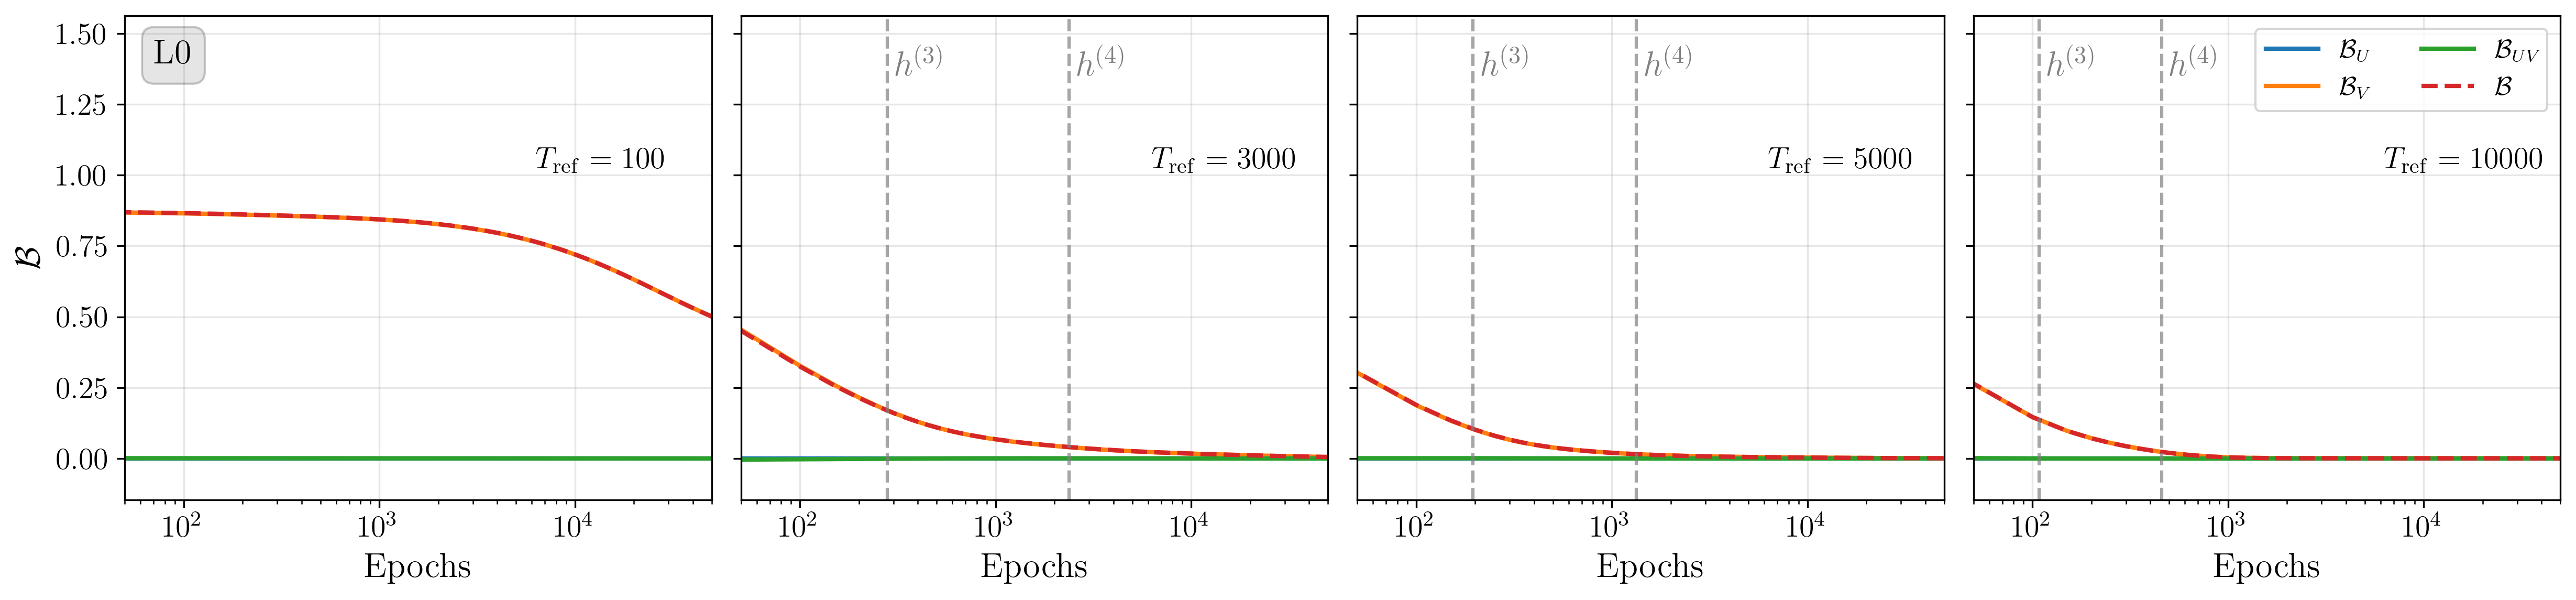

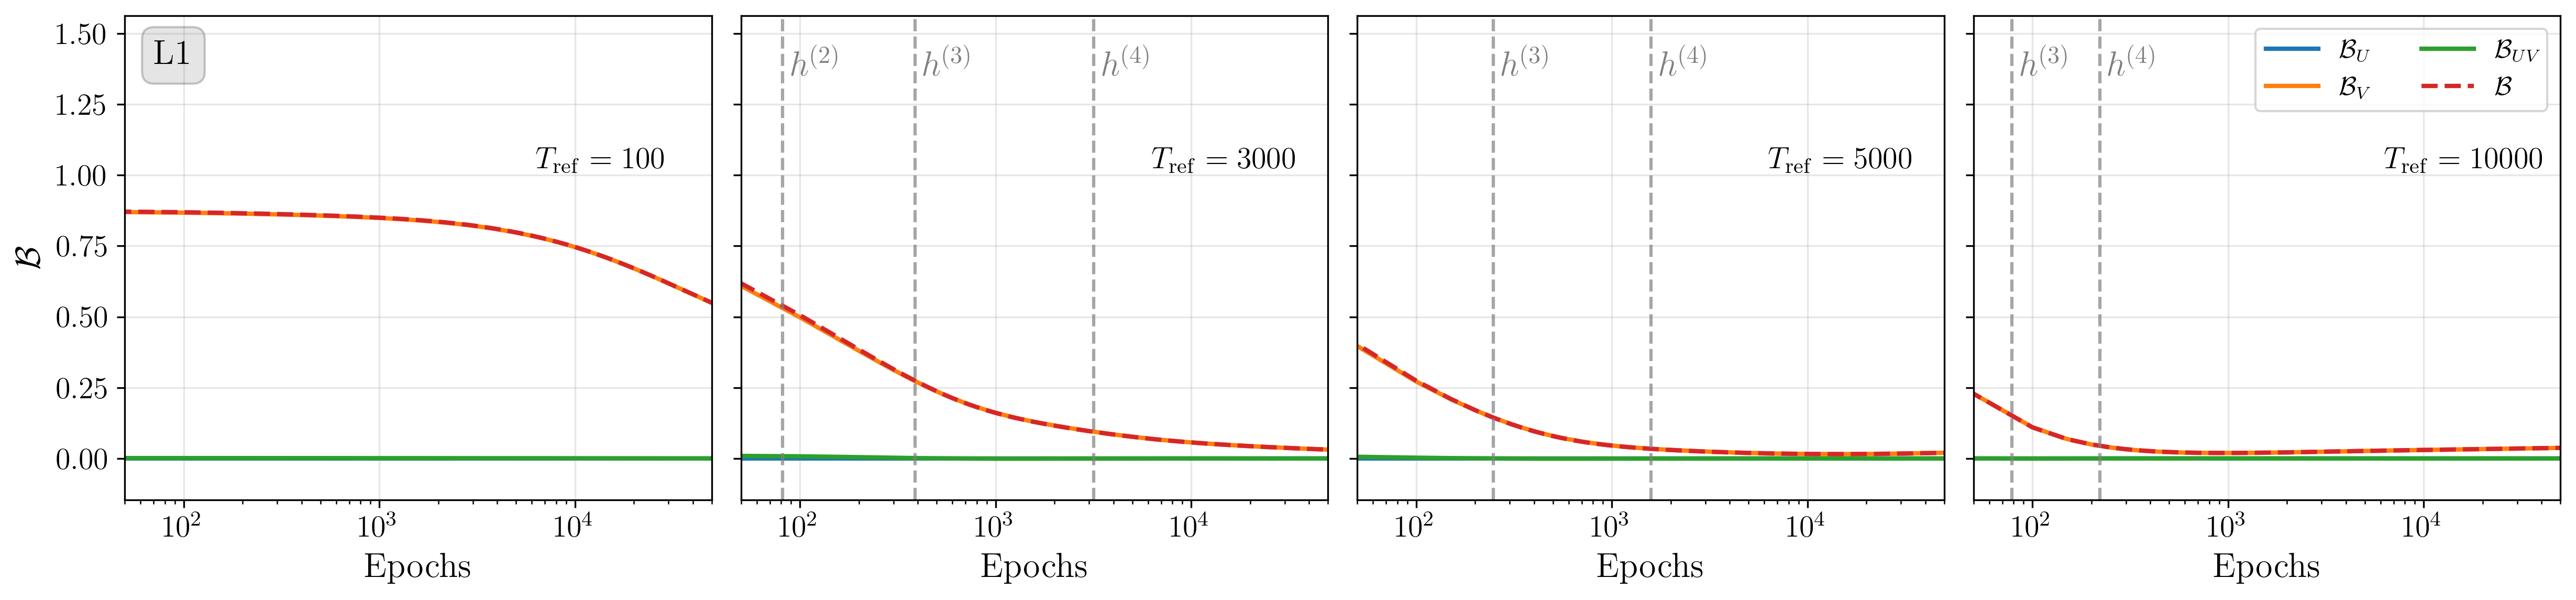

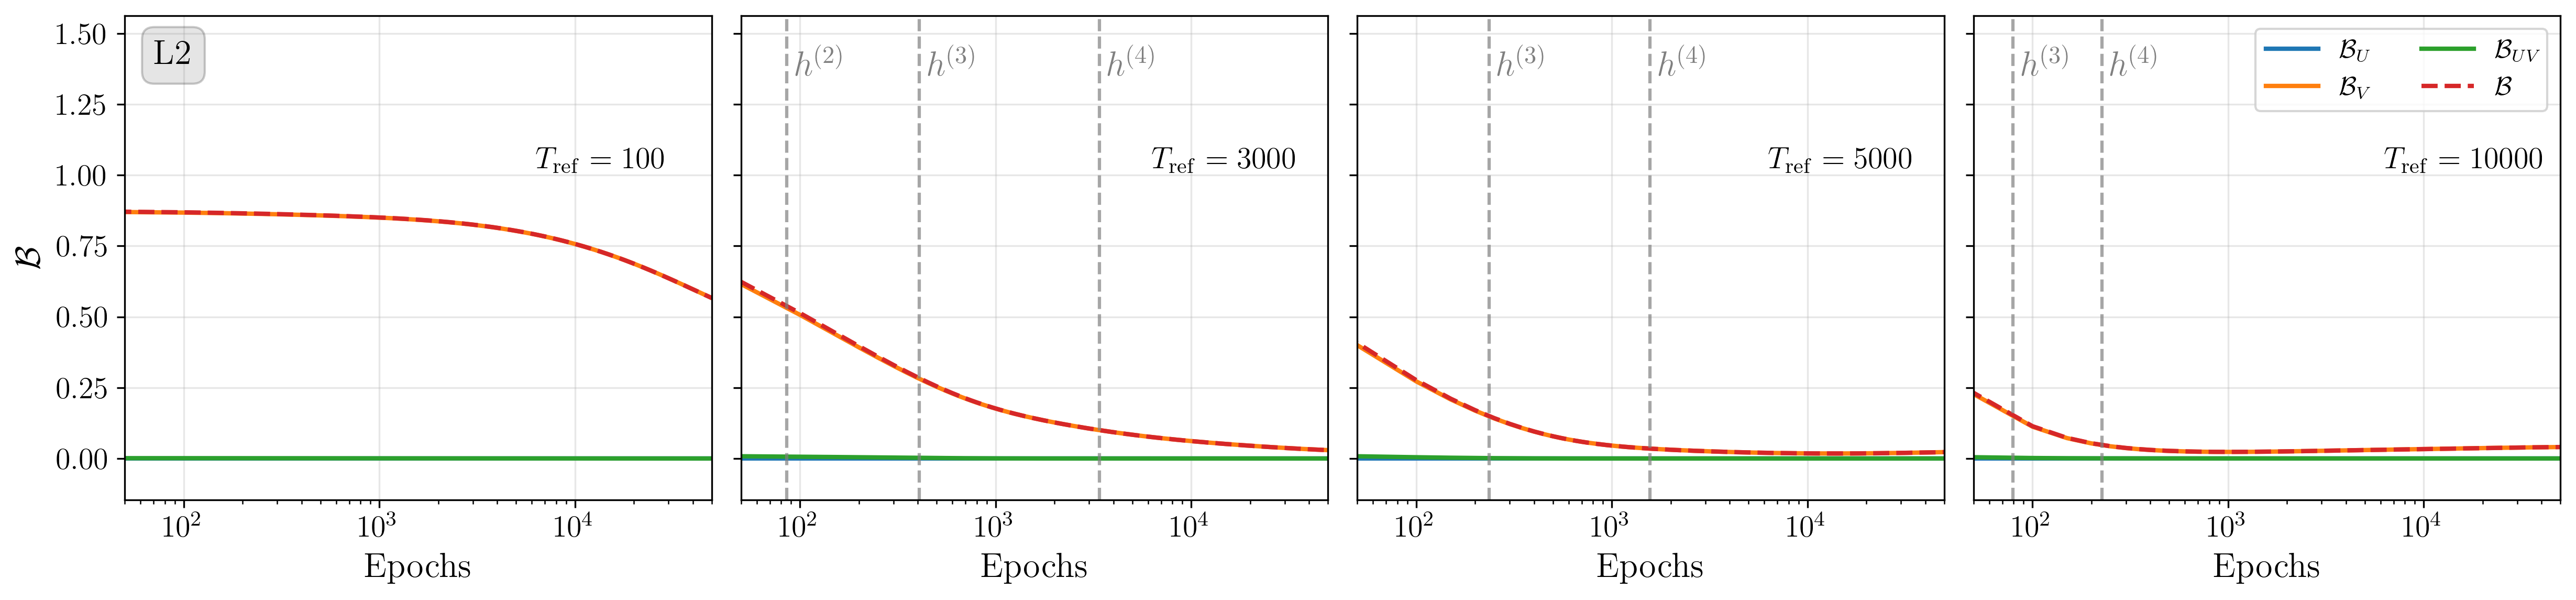

In [40]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.utils import load_data

SERIALIZATION_FOLDER = Path.cwd() / "serialization"

ref_epochs=[100, 3000, 5000, 10000]
epochs=np.linspace(0, 50000, 1000, dtype=int)
fin = f_in
Y_LO = FK @ fin

def make_plot(context, label):
  
  data_by_replica_original = load_data(context)
  Ndat = data_by_replica_original.shape[0]
  evolution = EvolutionOperatorComputer(context)
  M = context.get_M()
  Mpinv = np.linalg.pinv(M)
  fin_perp = Mpinv @ M @ fin
  fin_par = fin - fin_perp
  common_epochs = context.common_epochs

  nrows = 1
  ncols = len(ref_epochs)
  figsize = (5, 4)
  subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)
  learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])

  for i, ref_epoch in enumerate(ref_epochs):
      ax = axes[i]
      hinv = context.hinv_by_epoch[common_epochs.index(ref_epoch)].apply_operator(b=learning_rate, operator=lambda a, b: a / b)

      # try to load from file
      try:
          with open(SERIALIZATION_FOLDER / f"bias_{label}/bias_data_{label}_Tref_{ref_epoch}.npz", "rb") as f:
              bias_data = np.load(f)
              Bu_list = bias_data["Bu_list"]
              Bv_list = bias_data["Bv_list"]
              Buv_list = bias_data["Buv_list"]
              Btot_list = bias_data["Btot_list"]
          print(f"Loaded bias data from file for Tref={ref_epoch}")
      except FileNotFoundError:
          print(f"Computing bias data for Tref={ref_epoch}")
          Bu_list = []
          Bv_list = []
          Buv_list = []
          Btot_list = []
          for j, epoch in enumerate(epochs):
              evolution_time = epoch * learning_rate

              U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
              Uf0 = U @ f0
              VY = V @ data_by_replica_original

              Bu = 1 / Ndat * (Uf0.get_mean() - fin_par).T @ M @ (Uf0.get_mean() - fin_par)
              Bv = 1 / Ndat * (VY.get_mean() - fin_perp).T @ M @ (VY.get_mean() - fin_perp)
              Buv = 2 / Ndat * (Uf0.get_mean() - fin_par).T @ M @ (VY.get_mean() - fin_perp)

              Bu_list.append(Bu)
              Bv_list.append(Bv)
              Buv_list.append(Buv)
              Btot_list.append(Bu + Bv + Buv)

          # Save lists as arrays
          Bu_list = np.array(Bu_list)
          Bv_list = np.array(Bv_list)
          Buv_list = np.array(Buv_list)
          Btot_list = np.array(Btot_list)

          savedir = SERIALIZATION_FOLDER / f"bias_{label}"
          savedir.mkdir(parents=True, exist_ok=True)
          with open(savedir / f"bias_data_{label}_Tref_{ref_epoch}.npz", "wb") as f:
              np.savez(f, Bu_list=Bu_list, Bv_list=Bv_list, Buv_list=Buv_list, Btot_list=Btot_list)
          print(f"Saved bias data to file for Tref={ref_epoch}")

      _ = ax.plot(epochs, Bu_list, color="C0", linewidth=2, label=r"$\mathcal{B}_U$")
      _ = ax.plot(epochs, Bv_list, color="C1", linewidth=2, label=r"$\mathcal{B}_V$")
      _ = ax.plot(epochs, Buv_list, color="C2", linewidth=2, label=r"$\mathcal{B}_{UV}$")
      _ = ax.plot(epochs, Btot_list, color="C3", linewidth=2, ls="--", label=r"$\mathcal{B}$")

      if i != 0:
        for r in range(0,4):
          hinv_cv = hinv.get_median()[r]
          ax.axvline(hinv_cv, color='grey', linestyle='--', alpha=0.7)
          if hinv_cv < epochs[1]:
             continue
          ax.text(hinv_cv*(1+0.1), 1.35, rf"$h^{{({r+1})}}$", fontsize=16, color='grey')

      ax.grid(True, alpha=0.3)
      # ax.set_ylim(1.e-8, 4.0)
      ax.set_xlim(epochs[1], epochs[-1])
      # ax.set_yscale('log')
      ax.set_xscale('log')

      ax.tick_params(axis='y')
      ax.set_xlabel(r"$\rm{Epochs}$")
      ax.legend(loc='best', fontsize=12, ncol=2)

      if i != ncols - 1:
          ax.get_legend().set_visible(False)
          ax.text(0.65+0.05, 0.70, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      else:
          ax.text(0.65+0.05, 0.70, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

      if i == 0:
        ax.set_ylabel(r'$\mathcal{B}$')
        ax.text(0.05, 0.9, rf"$\rm{{{label}}}$", transform=ax.transAxes, fontsize=16, bbox=dict(boxstyle='round', facecolor='grey', alpha=0.2,edgecolor='black', pad=0.35))

  fig.savefig(THIS / f"section_4/bias/bias_{label}.pdf", bbox_inches='tight')

make_plot(context_L0, "L0")
make_plot(context_L1, "L1")
make_plot(context_L2, "L2")

Loaded variance data from file for Tref=100
Loaded variance data from file for Tref=3000
Loaded variance data from file for Tref=5000
Loaded variance data from file for Tref=10000
Loaded variance data from file for Tref=100
Loaded variance data from file for Tref=3000
Loaded variance data from file for Tref=5000
Loaded variance data from file for Tref=10000
Loaded variance data from file for Tref=100
Loaded variance data from file for Tref=3000
Loaded variance data from file for Tref=5000
Loaded variance data from file for Tref=10000


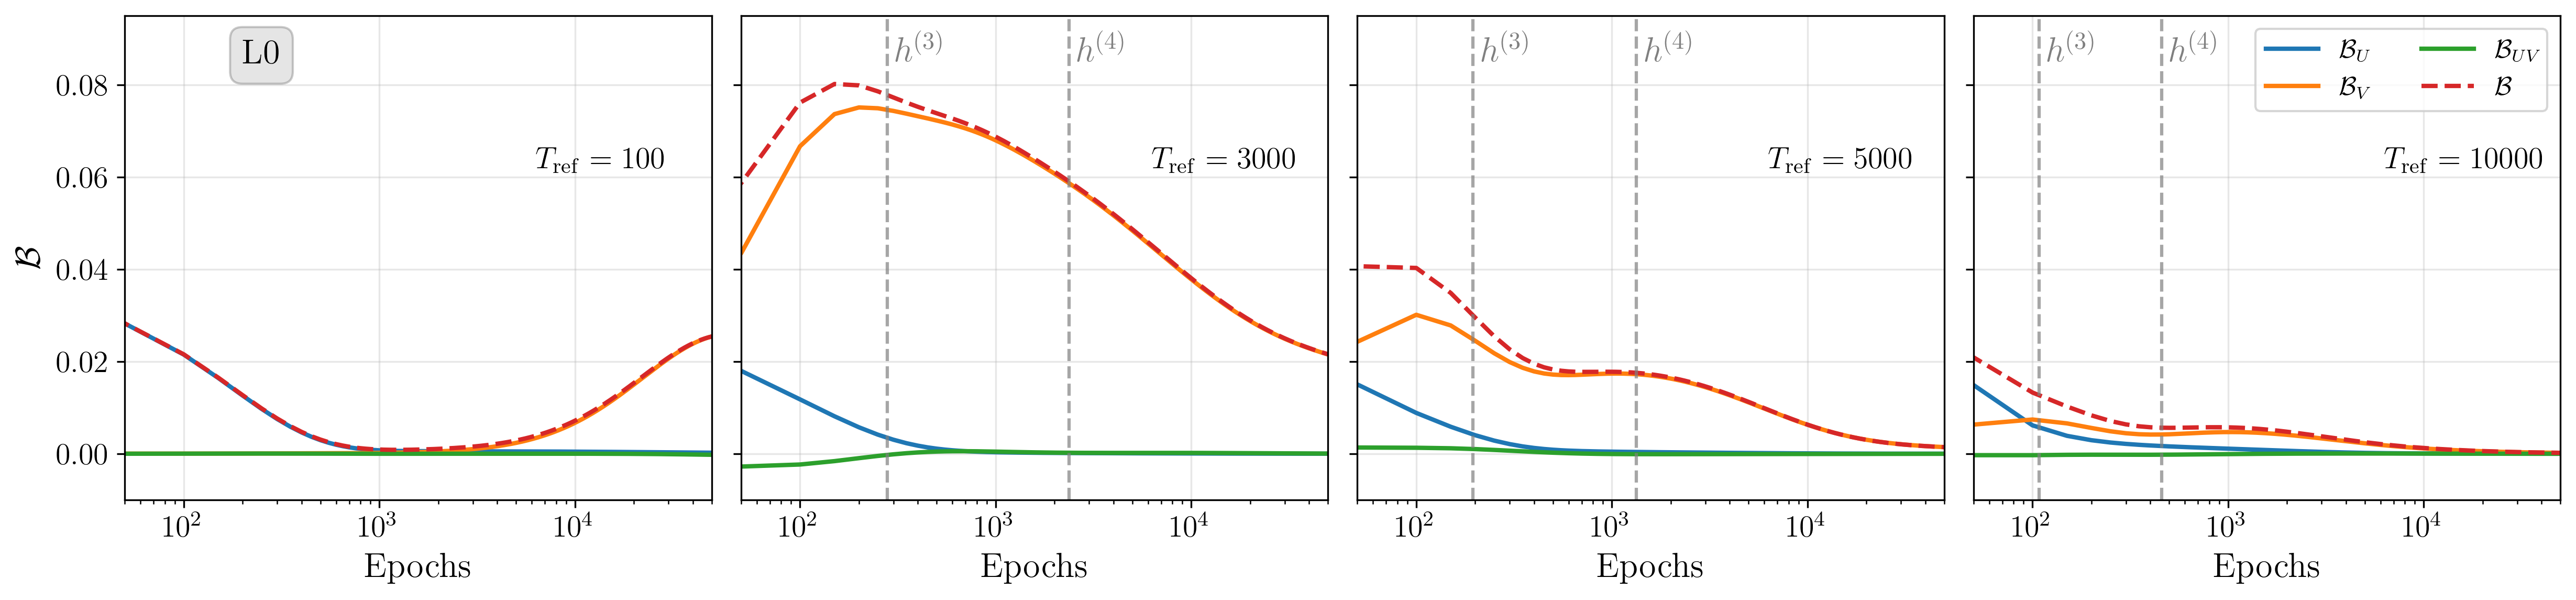

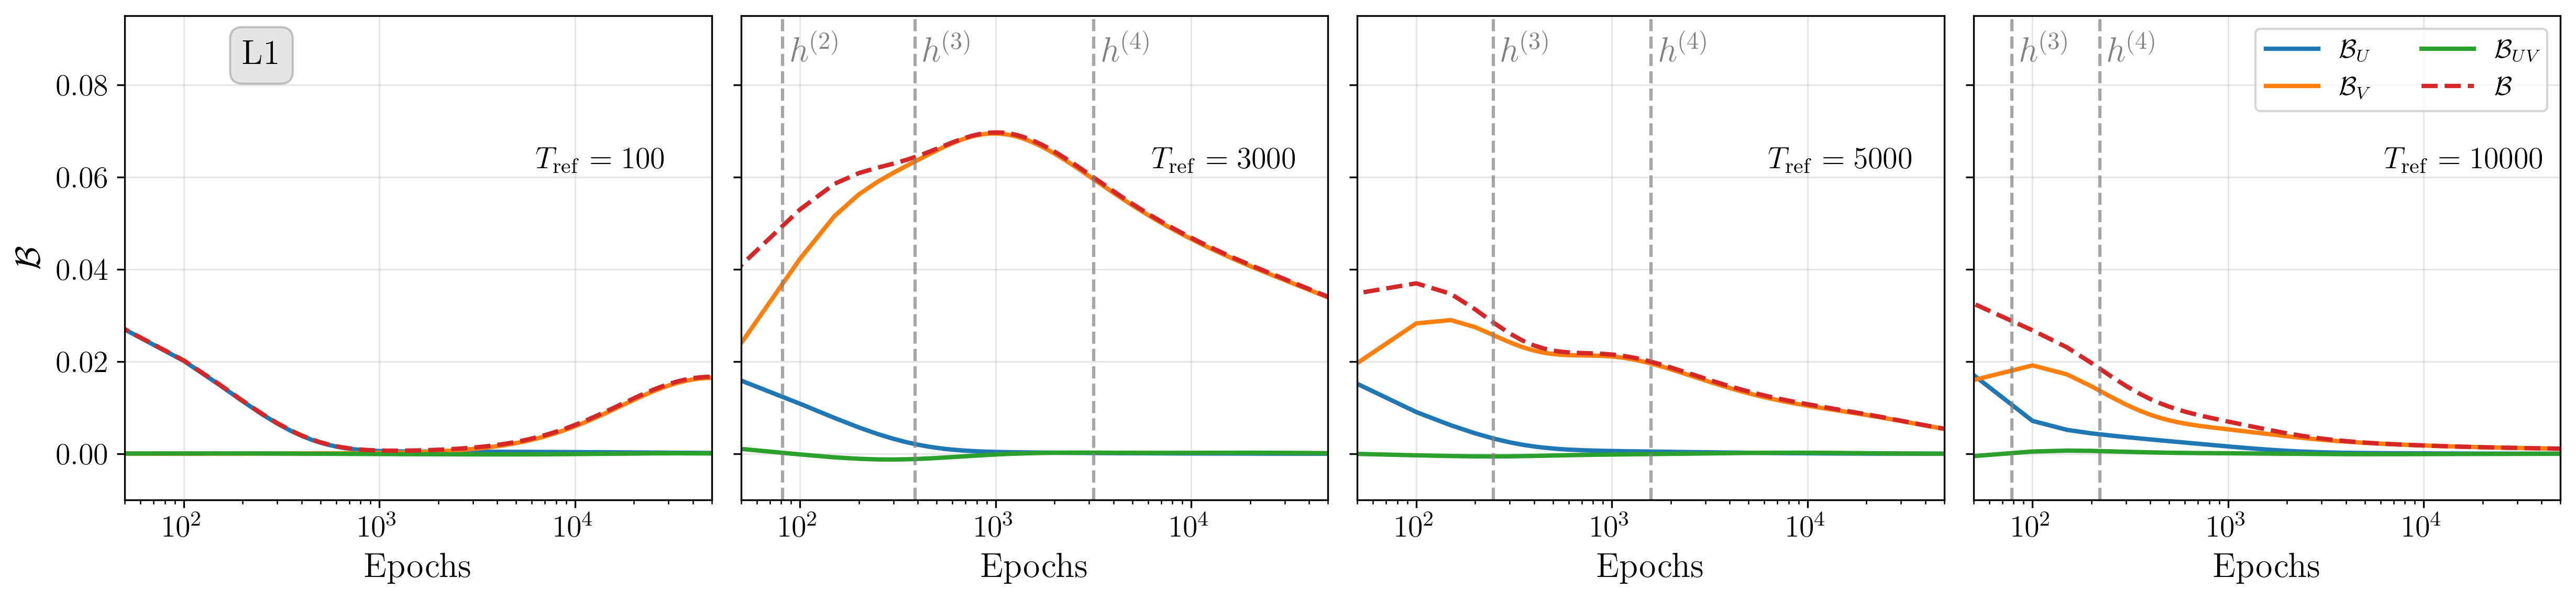

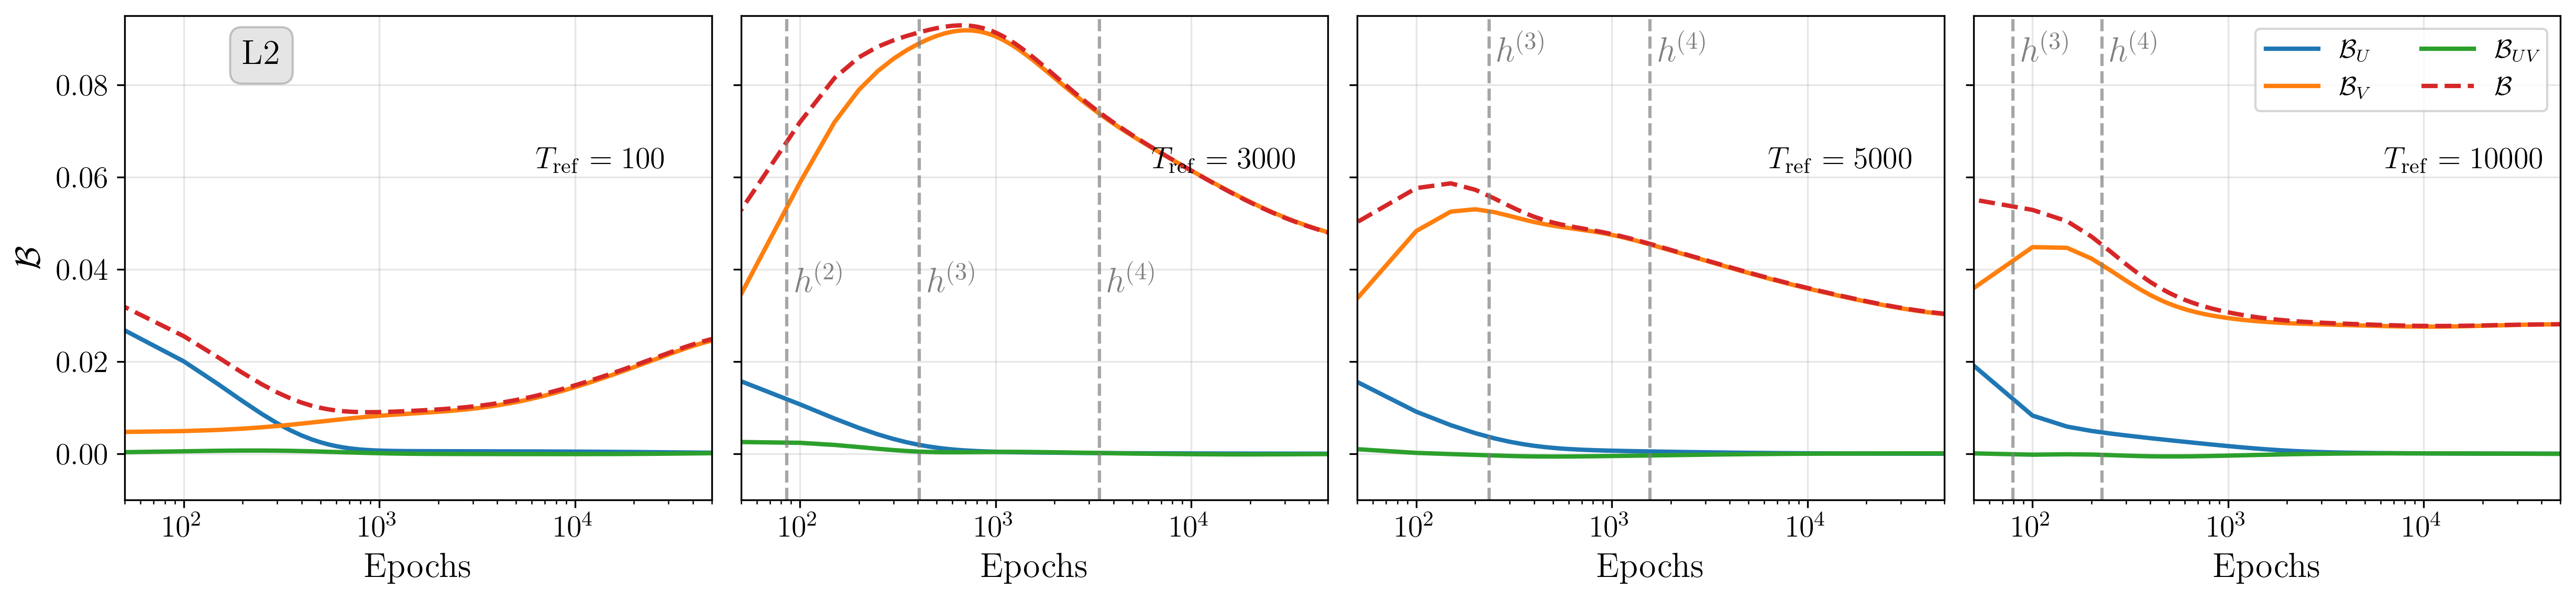

In [76]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.utils import load_data

ref_epochs=[100, 3000, 5000, 10000]
epochs=np.linspace(0, 50000, 1000, dtype=int)
fin = f_in
Y_LO = FK @ fin

def make_plot(context, label):
  
  data_by_replica_original = load_data(context)
  Ndat = data_by_replica_original.shape[0]
  evolution = EvolutionOperatorComputer(context)
  M = context.get_M()
  common_epochs = context.common_epochs

  nrows = 1
  ncols = len(ref_epochs)
  figsize = (5, 4)
  subplot_adjust = {"sharex": True, "sharey": True, 'gridspec_kw': {'wspace':0.05, 'hspace':0.05}}

  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * figsize[0], nrows * figsize[1]), **subplot_adjust)
  learning_rate = float(context.get_config("metadata", "arguments")["learning_rate"])

  for i, ref_epoch in enumerate(ref_epochs):
      ax = axes[i]
      hinv = context.hinv_by_epoch[common_epochs.index(ref_epoch)].apply_operator(b=learning_rate, operator=lambda a, b: a / b)

      try:
          with open(SERIALIZATION_FOLDER / f"variance_{label}/variance_data_{label}_Tref_{ref_epoch}.npz", "rb") as f:
              variance_data = np.load(f)
              Vu_list = variance_data["Vu_list"]
              Vv_list = variance_data["Vv_list"]
              Vuv_list = variance_data["Vuv_list"]
              Vtot_list = variance_data["Vtot_list"]
          print(f"Loaded variance data from file for Tref={ref_epoch}")
      except FileNotFoundError:
          print(f"Computing variance data for Tref={ref_epoch}")
          Vu_list = []
          Vv_list = []
          Vuv_list = []
          Vtot_list = []

          for j, epoch in enumerate(epochs):
              evolution_time = epoch * learning_rate

              U, V = evolution.compute_evolution_operator(ref_epoch, evolution_time)
              Uf0 = U @ f0
              VY = V @ data_by_replica_original

              Vu = 1 / Ndat * ((Uf0 - Uf0.get_mean()).transpose() @ M @ (Uf0 - Uf0.get_mean() )).get_mean()
              Vv = 1 / Ndat * ((VY - VY.get_mean()).transpose() @ M @ (VY - VY.get_mean())).get_mean()
              Vuv = 2 / Ndat * ((Uf0 - Uf0.get_mean()).transpose() @ M @ (VY - VY.get_mean())).get_mean()

              Vu_list.append(Vu)
              Vv_list.append(Vv)
              Vuv_list.append(Vuv)
              Vtot_list.append(Vu + Vv + Vuv)
            
          # Save lists as arrays
          Vu_list = np.array(Vu_list)
          Vv_list = np.array(Vv_list)
          Vuv_list = np.array(Vuv_list)
          Vtot_list = np.array(Vtot_list)
          savedir = SERIALIZATION_FOLDER / f"variance_{label}"
          savedir.mkdir(parents=True, exist_ok=True)
          with open(savedir / f"variance_data_{label}_Tref_{ref_epoch}.npz", "wb") as f:
              np.savez(f, Vu_list=Vu_list, Vv_list=Vv_list, Vuv_list=Vuv_list, Vtot_list=Vtot_list)
          print(f"Saved variance data to file for Tref={ref_epoch}")
    
      _ = ax.plot(epochs, Vu_list, color="C0", linewidth=2, label=r"$\mathcal{B}_U$")
      _ = ax.plot(epochs, Vv_list, color="C1", linewidth=2, label=r"$\mathcal{B}_V$")
      _ = ax.plot(epochs, Vuv_list, color="C2", linewidth=2, label=r"$\mathcal{B}_{UV}$")
      _ = ax.plot(epochs, Vtot_list, color="C3", linewidth=2, ls="--", label=r"$\mathcal{B}$")

      if i != 0:
        for r in range(0,4):
          hinv_cv = hinv.get_median()[r]
          ax.axvline(hinv_cv, color='grey', linestyle='--', alpha=0.7)
          if hinv_cv < epochs[1]:
             continue
          if 0.085 < np.max(Vtot_list[1:]):
             ax.text(hinv_cv*(1+0.1), 0.035, rf"$h^{{({r+1})}}$", fontsize=16, color='grey')
             continue
          ax.text(hinv_cv*(1+0.1), 0.085, rf"$h^{{({r+1})}}$", fontsize=16, color='grey')

      ax.grid(True, alpha=0.3)
      # ax.set_yscale('log')
      ax.set_xlim(epochs[1], epochs[-1])
      ax.set_ylim(-0.01, 0.095)
      ax.set_xscale('log')

      ax.tick_params(axis='y')
      ax.set_xlabel(r"$\rm{Epochs}$")
      ax.legend(loc='best', fontsize=12, ncol=2)

      if i != ncols - 1:
          ax.get_legend().set_visible(False)
          ax.text(0.65+0.05, 0.70, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)
      else:
          ax.text(0.65+0.05, 0.70, rf"$T_{{\rm ref}} = {{{ref_epoch}}}$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=14)

      if i == 0:
        ax.set_ylabel(r'$\mathcal{B}$')
        ax.text(0.2, 0.9, rf"$\rm{{{label}}}$", transform=ax.transAxes, fontsize=16, bbox=dict(boxstyle='round', facecolor='grey', alpha=0.2,edgecolor='black', pad=0.35))

  fig.savefig(THIS / f"section_4/variance/variance_{label}.pdf", bbox_inches='tight')

make_plot(context_L0, "L0")
make_plot(context_L1, "L1")
make_plot(context_L2, "L2")

# NTK Gaussian process?

In [ ]:
data_L0 = load_data(context_L0)
data_L1 = load_data(context_L1)
np.allclose(data_L0.get_data(), data_L1.get_data())

In [ ]:
from yadlt.evolution import EvolutionOperatorComputer
from yadlt.load_data import load_bcdms_cov, load_bcdms_pdf
from yadlt.load_data import load_bcdms_fk

cov_f0 = (f0 ^ f0).get_mean()
Cy = load_bcdms_cov()
replica_seed = 123231
rng_replica = np.random.default_rng(replica_seed)
rng_l1 = np.random.default_rng(13212)
FK = load_bcdms_fk()

L = np.linalg.cholesky(Cy)

y_L0 = FK @ f_bcdms
Y = load_data(context_L1)

f_bcdms = load_bcdms_pdf()
ref_epoch = 10000

# Load trained solution
for name, ctx in zip( ["L0", "L1", "L2"] ,[context_L0, context_L1, context_L2]):
  evolution = EvolutionOperatorComputer(ctx)
  learning_rate = float(ctx.get_config("metadata", "arguments")["learning_rate"])
  t = 5000000000 * learning_rate
  U, V = evolution.compute_evolution_operator(ref_epoch, t)

  m = np.zeros_like(fk_grid)
  cov = np.zeros((fk_grid.size, fk_grid.size))

  for rep in range(U.size):
    cov += U[rep] @ cov_f0 @ U[rep].T + V[rep] @ Cy @ V[rep].T
    m += V[rep] @ Y[rep]

  m = m / U.size
  cov = cov / U.size

  # pl = plt.plot(fk_grid, m)
  pl = plt.plot(fk_grid, m, label=name)
  plt.fill_between(fk_grid, m - np.sqrt(cov.diagonal()), m + np.sqrt(cov.diagonal()), alpha=0.4, color=pl[0].get_color())
  # plt.plot(fk_grid, V[12] @ Y)
  # plt.plot(fk_grid, V[43] @ Y)
  # plt.plot(fk_grid, V[76] @ Y)
  # plt.plot(fk_grid, V[95] @ Y)

plt.plot(fk_grid, f_bcdms, linestyle='--', color='black', label=r"$\rm{Input~function}$")
plt.legend()

# TEsts

In [ ]:
# Generate matrix from function
ntk = np.zeros((fk_grid.size, fk_grid.size))
for i, x in enumerate(fk_grid):
    for j, y in enumerate(fk_grid):
        ntk[i, j] = 1 + x * y

size = ntk.shape[0]

# Compute eigenvalues and eigenvectors of the NTK
Z, eigenvalues, ZrT = np.linalg.svd(ntk, hermitian=True)

# Compute frobenius norm
frob_norm = np.sqrt(np.sum([s**2 for s in eigenvalues]))

for idx in range(len(eigenvalues)):
    if not np.allclose(Z[:, idx], ZrT.T[:, idx]):
        cut = idx
        break

for i in range(cut, 0, -1):
    if eigenvalues[i] / eigenvalues[0] > 1.0e-7:
        cut = np.int64(i + 1)
        break

perp_mask = [True] * cut + [False] * (size - cut)
parallel_mask = ~np.array(perp_mask)

Lambda_perp = eigenvalues[perp_mask]
Z_perp = Z[:, perp_mask]
Z_parallel = Z[:, parallel_mask]

# Parallel projector
P_parallel = np.empty((size, size))
P_perp = np.empty((size, size))
P_parallel = np.dot(Z_parallel, Z_parallel.T)
P_perp = np.dot(Z_perp, Z_perp.T)

In [ ]:
plt.plot(fk_grid, Z[:,0])
plt.plot(fk_grid, Z[:,1])
plt.plot(fk_grid, Z[:,-1])

In [ ]:
ctx = context_L2
common_epochs = ctx.get_config("replicas", "common_epochs")

def make_plot(scale: "linear"):
  fig, axs = plt.subplots(2, 5, figsize=(5*5, 4), sharex=True, sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.1}, height_ratios=[3,1.5])

  for idx, epoch in enumerate([0, 1000, 5000, 10000, 50000]):
    ax = axs[0, idx]
    ratio_ax = axs[1, idx]

    P_parallel_ctx = ctx.P_parallel_by_epoch[common_epochs.index(epoch)]
    P_perp_ctx = ctx.P_perp_by_epoch[common_epochs.index(epoch)]
    f_par = P_parallel_ctx @ f_bcdms
    f_perp = P_perp_ctx @ f_bcdms

    ax.plot(fk_grid, f_bcdms, linestyle='-.', color='black', label=r"$\rm{Input~function}$")

    ax.plot(fk_grid, P_perp @ f_bcdms, label=r"$P_{\perp}~\rm{linear}$", ls="--", color="C0")
    ax.plot(fk_grid, P_parallel @ f_bcdms, label=r"$$P_{\parallel}~\rm{linear}$$", ls="--", color="C1")
    ratio_ax.plot(fk_grid, f_bcdms / f_bcdms, linestyle='-.', color='black')

    # ratio_ax.plot(fk_grid, P_perp @ f_bcdms / f_bcdms, ls="--", color="C0")
    # ratio_ax.plot(fk_grid, P_parallel @ f_bcdms / f_bcdms, ls="--", color="C1")

    ax.plot(fk_grid, f_perp.get_mean(), label=r"$P_{\perp}~\rm{NTK}$", color="C2")
    ax.plot(fk_grid, f_par.get_mean(), label=r"$P_{\parallel}~\rm{NTK}$", color="C3")
    ax.fill_between(fk_grid, f_perp.get_mean() - f_perp.get_std(), f_perp.get_mean() + f_perp.get_std(), alpha=0.4, color="C2")
    ax.fill_between(fk_grid, f_par.get_mean() - f_par.get_std(), f_par.get_mean() + f_par.get_std(), alpha=0.4, color="C3")
    f_perp_f_bcdms = f_perp / f_bcdms
    f_par_f_bcdms = f_par / f_bcdms
    ratio_ax.plot(fk_grid, f_perp_f_bcdms.get_mean(), color="C2")
    ratio_ax.plot(fk_grid, f_par_f_bcdms.get_mean(), color="C3")
    ratio_ax.fill_between(fk_grid, f_perp_f_bcdms.get_mean() - f_perp_f_bcdms.get_std(), f_perp_f_bcdms.get_mean() + f_perp_f_bcdms.get_std(), alpha=0.4, color="C2")
    ratio_ax.fill_between(fk_grid, f_par_f_bcdms.get_mean() - f_par_f_bcdms.get_std(), f_par_f_bcdms.get_mean() + f_par_f_bcdms.get_std(), alpha=0.4, color="C3")

    ratio_ax.set_ylim(0.5, 1.5)
    ax.set_xscale(scale)

  ax.legend()

make_plot("linear")

In [ ]:
ctx = context_L0
common_epochs = ctx.get_config("replicas", "common_epochs")
P_parallel_ctx = ctx.P_parallel_by_epoch[common_epochs.index(0)]
P_perp_ctx = ctx.P_perp_by_epoch[common_epochs.index(0)]

replicas = []
for r in range(100):
  replicas.append(P_parallel @ f0[r])

mean = np.mean(replicas, axis=0)
std = np.std(replicas, axis=0)


# plt.plot(fk_grid, P_perp @ finit, label=r"$P_{\perp}~\rm{linear}$", ls="--")
plt.plot(fk_grid, mean, label=r"$$P_{\parallel}~\rm{linear}$$", ls="--", color='C1')
plt.fill_between(fk_grid, mean - std, mean + std, alpha=0.4, color='C1')

# plt.plot(fk_grid, P_perp_ctx @ finit, label=r"$P_{\perp}~\rm{NTK}$")
plt.plot(fk_grid, (P_parallel_ctx @ f0).get_mean(), label=r"$P_{\parallel}~\rm{NTK}$", color='C2')
plt.fill_between(fk_grid,
                 (P_parallel_ctx @ f0).get_mean() - (P_parallel_ctx @ f0).get_std(), 
                 (P_parallel_ctx @ f0).get_mean() + (P_parallel_ctx @ f0).get_std(),
                 alpha=0.4, color='C2',
                 )

plt.legend()

In [ ]:
import pickle

fig, ax = make_figure(axes_width=8.0, axes_height=4.8, top_margin=0.5, bottom_margin=0.92)
SERIALIZATION_FOLDER = Path.cwd() / "serialization"
arch = [25, 20]

group_dict = {}
ntk = pickle.load(open(SERIALIZATION_FOLDER / f"ntk_initialization_{arch[0]}.pkl", "rb"))[23]

eigvals, _ = np.linalg.eigh(ntk)
eigvals = np.sort(eigvals)[::-1]

left, sing_vals, right = np.linalg.svd(ntk, hermitian=True)
sing_vals = np.sort(sing_vals)[::-1]

for i in range(len(eigvals)):
    if not np.allclose(left[:, i], right.T[:, i]):
        cut = i
        break

# Compute the numerical precision limit
rtol = np.power(10.,-8)
precision_limit = rtol * sing_vals[0]


# Store handles for legend
handles = []
labels = []

_ = ax.plot(sing_vals, color="C0", label=r"$\rm Singular~values$", ls="--")
_ = ax.plot(eigvals, color="C1", label=r"$\rm Eigenvalues$", ls="-", alpha=0.7)
ax.hlines(1.e-7 * sing_vals[0], 0, 50, color="black", ls="-", label=r"$\rm{Cutoff}~\lambda_{\rm cut}$")
ax.fill_between([0, 50], 4*precision_limit, precision_limit, color="grey", alpha=0.3, label=r"$\textrm{Numerical noise}$")
ax.set_yscale("log")
ax.set_xlabel(r"$\rm Index$")

ax.legend()
fig.tight_layout()
fig.savefig(THIS / "appendix_cutoff/cutoff.pdf", bbox_inches='tight')

print(f"Lower tolerance limit: {rtol}")
print(f"Upper tolerance limit: {4*rtol}")